# Semantic Person Search

| Contribution   |
| :---   |
| Leonardo Villamil  |
| Litian Chen        | 

In [2]:
import cv2
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, SpatialDropout2D, Activation, Flatten, Dropout
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from sklearn.utils import class_weight
from tensorflow import keras
from tensorflow.keras import layers

import pydot
import IPython
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot, plot_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Load Data form CSV Files

In [3]:
train_csv = pd.read_csv('Data/Q2/Train_Data/Train.csv')
test_csv = pd.read_csv('Data/Q2/Test_Data/Test.csv')

train_csv.drop(columns=['pose','torcol2', 'torcol3', 'tortex', 'legcol2', 'legcol3', 'legtex'], inplace=True)
test_csv.drop(columns=['pose','torcol2', 'torcol3', 'tortex', 'legcol2', 'legcol3', 'legtex'], inplace=True)

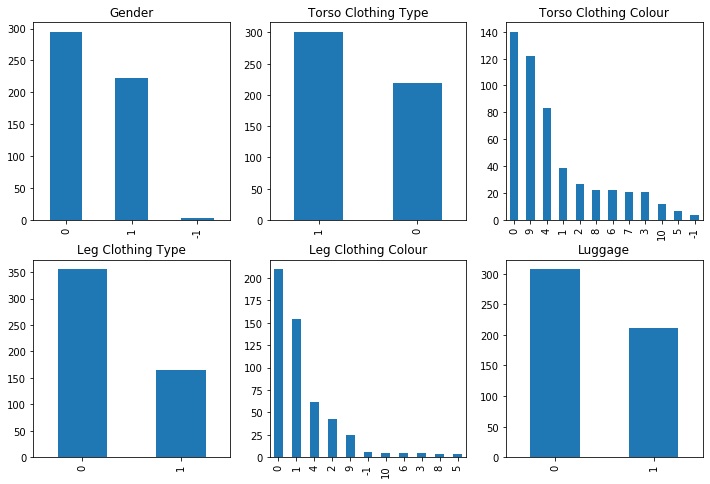

In [4]:
# Training Set
fig = plt.figure(figsize=[12, 8])
ax = fig.add_subplot(2, 3, 1)
train_csv['gender'].value_counts().plot(kind='bar')
ax.set_title('Gender');
ax = fig.add_subplot(2, 3, 2)
train_csv['tortyp'].value_counts().plot(kind='bar')
ax.set_title('Torso Clothing Type');
ax = fig.add_subplot(2, 3, 3)
train_csv['torcol'].value_counts().plot(kind='bar')
ax.set_title('Torso Clothing Colour');
ax = fig.add_subplot(2, 3, 4)
train_csv['legtyp'].value_counts().plot(kind='bar')
ax.set_title('Leg Clothing Type');
ax = fig.add_subplot(2, 3, 5)
train_csv['legcol'].value_counts().plot(kind='bar')
ax.set_title('Leg Clothing Colour');
ax = fig.add_subplot(2, 3, 6)
train_csv['luggage'].value_counts().plot(kind='bar')
ax.set_title('Luggage');

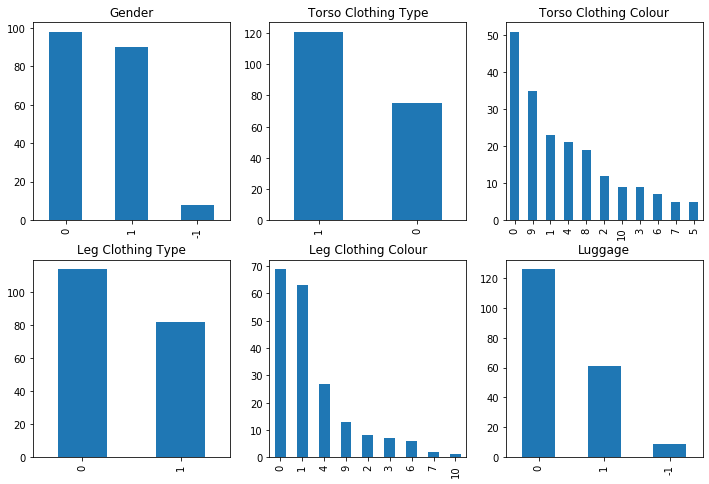

In [5]:
# Testing Set
fig = plt.figure(figsize=[12, 8])
ax = fig.add_subplot(2, 3, 1)
test_csv['gender'].value_counts().plot(kind='bar')
ax.set_title('Gender');
ax = fig.add_subplot(2, 3, 2)
test_csv['tortyp'].value_counts().plot(kind='bar')
ax.set_title('Torso Clothing Type');
ax = fig.add_subplot(2, 3, 3)
test_csv['torcol'].value_counts().plot(kind='bar')
ax.set_title('Torso Clothing Colour');
ax = fig.add_subplot(2, 3, 4)
test_csv['legtyp'].value_counts().plot(kind='bar')
ax.set_title('Leg Clothing Type');
ax = fig.add_subplot(2, 3, 5)
test_csv['legcol'].value_counts().plot(kind='bar')
ax.set_title('Leg Clothing Colour');
ax = fig.add_subplot(2, 3, 6)
test_csv['luggage'].value_counts().plot(kind='bar')
ax.set_title('Luggage');

In [6]:
# Set outputs to categorical
y_train_gender = to_categorical(train_csv['gender'], num_classes=2)
mask_idx = train_csv['gender'] == -1
y_train_gender[mask_idx] = -1

y_train_tortyp = to_categorical(train_csv['tortyp'], num_classes=2)
mask_idx = train_csv['tortyp'] == -1
y_train_tortyp[mask_idx] = -1

y_train_torcol = to_categorical(train_csv['torcol'], num_classes=11)
mask_idx = train_csv['torcol'] == -1
y_train_torcol[mask_idx] = -1

y_train_legtyp = to_categorical(train_csv['legtyp'], num_classes=2)
mask_idx = train_csv['legtyp'] == -1
y_train_legtyp[mask_idx] = -1

y_train_legcol = to_categorical(train_csv['legcol'], num_classes=11)
mask_idx = train_csv['legcol'] == -1
y_train_legcol[mask_idx] = -1

y_train_luggage = to_categorical(train_csv['luggage'], num_classes=2)
mask_idx = train_csv['luggage'] == -1
y_train_luggage[mask_idx] = -1

In [7]:
# Set outputs to categorical
y_test_gender = to_categorical(test_csv['gender'], num_classes=2)
mask_idx = test_csv['gender'] == -1
y_test_gender[mask_idx] = -1

y_test_tortyp = to_categorical(test_csv['tortyp'], num_classes=2)
mask_idx = test_csv['tortyp'] == -1
y_test_tortyp[mask_idx] = -1

y_test_torcol = to_categorical(test_csv['torcol'], num_classes=11)
mask_idx = test_csv['torcol'] == -1
y_test_torcol[mask_idx] = -1

y_test_legtyp = to_categorical(test_csv['legtyp'], num_classes=2)
mask_idx = test_csv['legtyp'] == -1
y_test_legtyp[mask_idx] = -1

y_test_legcol = to_categorical(test_csv['legcol'], num_classes=11)
mask_idx = test_csv['legcol'] == -1
y_test_legcol[mask_idx] = -1

y_test_luggage = to_categorical(test_csv['luggage'], num_classes=2)
mask_idx = test_csv['luggage'] == -1
y_test_luggage[mask_idx] = -1

## Load Data from Images

In [8]:
# Load train file and Mask convertion into a 'categorical' type image
def load_train_file(filename, labels, dim):
    im = cv2.cvtColor(cv2.imread('Data/Q2/Train_Data/Originals/' + filename), cv2.COLOR_BGR2RGB)/255
    im = cv2.resize(im, dim, interpolation = cv2.INTER_NEAREST)

    mask = np.zeros((im.shape[0], im.shape[1]))
    count = 0;
    
    for label in labels:
        count += 1
        path = 'Data/Q2/Train_Data/Binary_Maps/'  + filename
        path = path[:len(path)-4]
        try:
            temp = cv2.cvtColor(cv2.imread(path + '_' + label + '.png'), cv2.COLOR_BGR2GRAY)/255
            temp = cv2.resize(temp, dim, interpolation = cv2.INTER_NEAREST)
        except:
            temp = np.zeros((im.shape[0], im.shape[1]))
        mask = np.where(temp == 1, count, mask) 

    mask = np.where(mask == 0, 9, mask)
    mask = mask.astype('int')

    return im, mask

# Load test file
def load_test_file(filename, dim):
    im = cv2.cvtColor(cv2.imread('Data/Q2/Test_Data/Originals/' + filename), cv2.COLOR_BGR2RGB)/255
    im = cv2.resize(im, dim, interpolation = cv2.INTER_NEAREST)

    return im

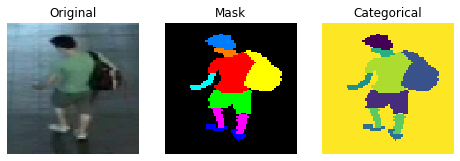

In [9]:
labels = ['hair', 'legs', 'luggage', 'shoes', 'skin_arms', 'skin_face', 'skin_legs', 'torso']
dim = (80, 80)

filename = train_csv['filename'].to_numpy()[1]

mask_full = cv2.cvtColor(cv2.imread('Data/Q2/Train_Data/Parsed/'  + filename), cv2.COLOR_BGR2RGB)/255
mask_full = cv2.resize(mask_full, dim, interpolation = cv2.INTER_NEAREST)

im, mask = load_train_file(filename, labels, dim)

fig = plt.figure(figsize=[8, 9])
ax = fig.add_subplot(1, 3, 1)
ax.imshow(im)
ax.set_axis_off()
ax.set_title('Original')
ax = fig.add_subplot(1, 3, 2)
ax.imshow(mask_full)
ax.set_axis_off()
ax.set_title('Mask')
ax = fig.add_subplot(1, 3, 3)
ax.imshow(mask)
ax.set_axis_off()
ax.set_title('Categorical');

In [10]:
# Load training and testing images
labels = ['hair', 'legs', 'luggage', 'shoes', 'skin_arms', 'skin_face', 'skin_legs', 'torso']
dim = (80, 80)

X_train = []
X_train_mask = []
X_test = []

for filename in train_csv['filename']:
    im, mask = load_train_file(filename, labels, dim)
    X_train.append(im)
    X_train_mask.append(mask)

for filename in test_csv['filename']:
    im = load_test_file(filename, dim)
    X_test.append(im)

X_train = np.asarray(X_train)
X_train_mask = np.asarray(X_train_mask)
X_train_mask = np.reshape(X_train_mask, (520,80,80,1))
X_test = np.asarray(X_test)

In [11]:
def mask_to_categorical(im, num_classes):    
    one_hot_map = []
    for i in range(num_classes):
        class_map = tf.reduce_all(tf.equal(im, i+1), axis=-1)
        one_hot_map.append(class_map)
    one_hot_map = tf.stack(one_hot_map, axis=-1)
    one_hot_map = tf.cast(one_hot_map, tf.float32)    
    return one_hot_map

def categorical_to_mask(im):
    mask = tf.dtypes.cast(tf.argmax(im, axis=2), 'float32') / 255.0
    return mask

In [12]:
X_train_mask_categorical = []

for i in range(len(X_train_mask)):
    im = mask_to_categorical(X_train_mask[i,:,:,:], 9)
    X_train_mask_categorical.append(im)

X_train_mask_categorical = np.asarray(X_train_mask_categorical)

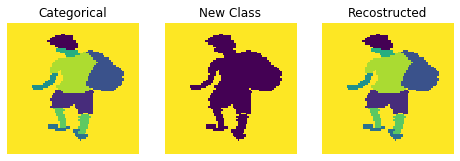

In [13]:
fig = plt.figure(figsize=[8, 9])
ax = fig.add_subplot(1, 3, 1)
ax.imshow(X_train_mask[1,:,:,0])
ax.set_axis_off()
ax.set_title('Categorical')

ax = fig.add_subplot(1, 3, 2)
ax.imshow(X_train_mask_categorical[1,:,:,8])
ax.set_axis_off()
ax.set_title('New Class')

ax = fig.add_subplot(1, 3, 3)
ax.imshow(categorical_to_mask(X_train_mask_categorical[1,:,:,:]))
ax.set_axis_off()
ax.set_title('Recostructed');

## Network with single Output

In [14]:
def masked_cce(y_true, y_pred):
    y_true_masked = tf.boolean_mask(y_true, tf.reduce_any(tf.not_equal(y_true, -1), 1))
    y_pred_masked = tf.boolean_mask(y_pred, tf.reduce_any(tf.not_equal(y_true, -1), 1))
    return K.mean(K.categorical_crossentropy(y_true_masked, y_pred_masked))

In [35]:
def eval_model(model, x_test, y_test, history, n_classes):
    pred, decoded_imgs = model.predict(x_test);

    fig = plt.figure(figsize=[10, 6])
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(history.history['loss'], label="Training Loss")
    ax.plot(history.history['gender_output_loss'], label="Gender Loss")
    ax.plot(history.history['autoenc_output_loss'], label="Autoenc Loss")
    ax.legend()
    ax.set_title('Training Loss')

    fig = plt.figure(figsize=[10, 6])
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(history.history['val_loss'], label="Validation Loss")
    ax.plot(history.history['val_gender_output_loss'], label="Gender Loss")
    ax.plot(history.history['val_autoenc_output_loss'], label="Autoenc Loss")
    ax.legend()
    ax.set_title('Validation Loss')

    fig = plt.figure(figsize=[6, 6])

    indexes = tf.argmax(pred, axis=1)
    gt = tf.argmax(y_test, axis=1)
    cm = confusion_matrix(gt, indexes, labels=range(n_classes), normalize='true')
    ax = fig.add_subplot(1, 1, 1)
    c = ConfusionMatrixDisplay(cm,display_labels=range(n_classes))
    c.plot(ax = ax)
    ax.set_title('Gender')

    n = 10
    fig = plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i+1)
        ax.imshow(x_test[i])
        ax.set_axis_off()

        # display reconstruction
        ax = plt.subplot(2, n, i + n + 1)
        ax.imshow(decoded_imgs[i])
        ax.set_axis_off()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80, 80, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 80, 80, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 20, 20, 16)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 20, 20, 8)    1160        max_pooling2d[0][0]              
______________________________________________________________________________________________

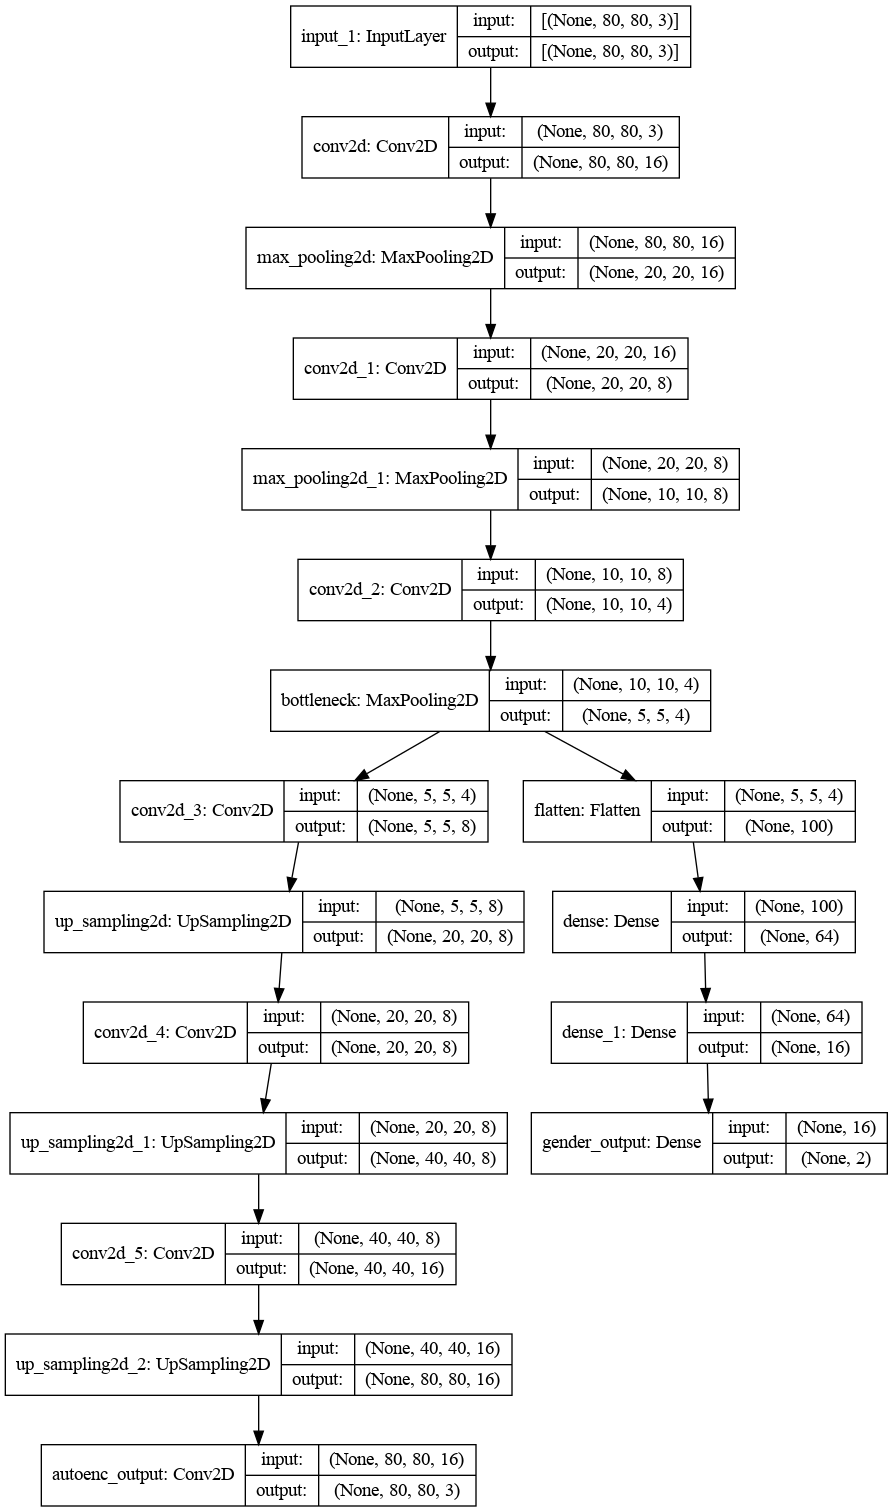

In [36]:
input_img = Input(shape=(80, 80, 3))

conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
pool1 = MaxPooling2D((4, 4), padding='same')(conv1)

conv2 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool1)
pool2 = MaxPooling2D((2, 2), padding='same')(conv2)

conv3 = Conv2D(4, (3, 3), activation='relu', padding='same')(pool2)

encoded = MaxPooling2D((2, 2), padding='same', name='bottleneck')(conv3)

# Autoencoder Output
conv4 = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
up1 = UpSampling2D((4, 4))(conv4)

conv5 = Conv2D(8, (3, 3), activation='relu', padding='same')(up1)
up2 = UpSampling2D((2, 2))(conv5)

conv6 = Conv2D(16, (3, 3), activation='relu', padding='same')(up2)
up3 = UpSampling2D((2, 2))(conv6)

decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same', name='autoenc_output')(up3)

flatten = Flatten()(encoded)

# gender Output
gender_out = Dense(64, activation='relu')(flatten)
gender_out = Dense(16, activation='relu')(gender_out)
gender_out = Dense(2, activation='softmax', name='gender_output')(gender_out)

multitask_cnn = Model(input_img, [gender_out, decoded])

multitask_cnn.compile(optimizer='adam', loss=[masked_cce, 'mean_squared_error'], loss_weights=[1, 0.5])

print(multitask_cnn.summary())

plot_model(multitask_cnn, show_shapes=True)

In [37]:
history = multitask_cnn.fit(X_train, [y_train_gender, X_train],
                    batch_size=32,
                    epochs=100,
                    validation_data=(X_test, [y_test_gender, X_test]), verbose=0)

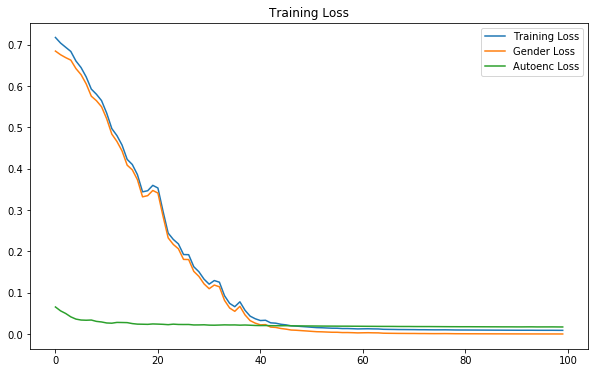

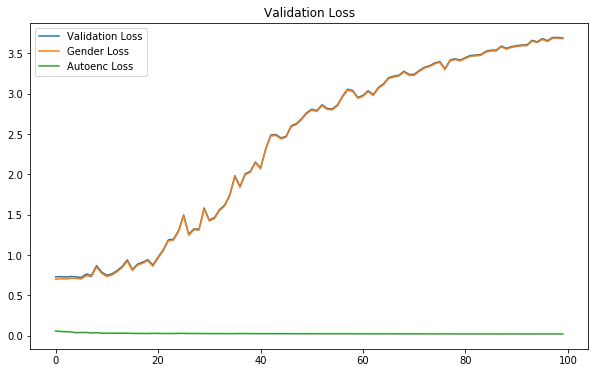

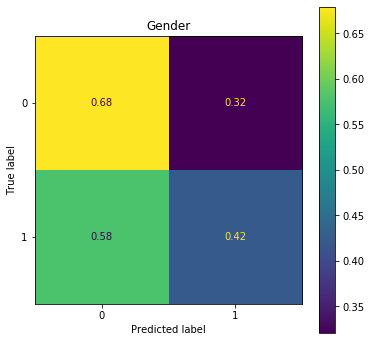

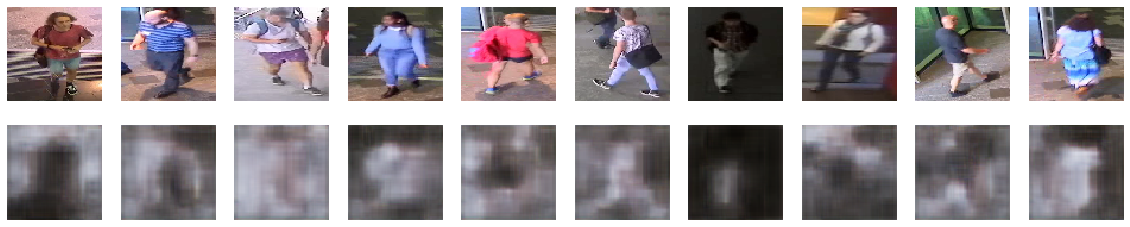

In [38]:
eval_model(multitask_cnn, X_test, y_test_gender, history, 2)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 80, 80, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 80, 80, 16)   448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 80, 80, 16)   64          conv2d_6[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 80, 80, 16)   0           batch_normalization[0][0]        
____________________________________________________________________________________________

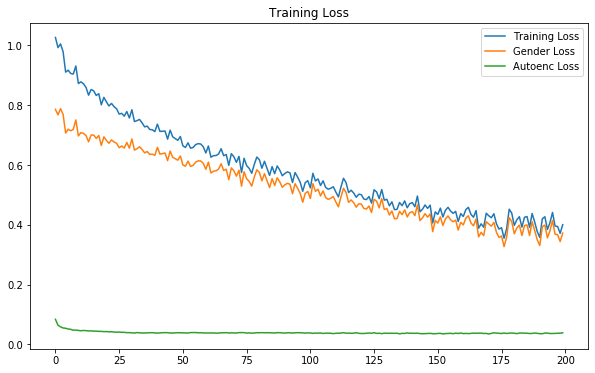

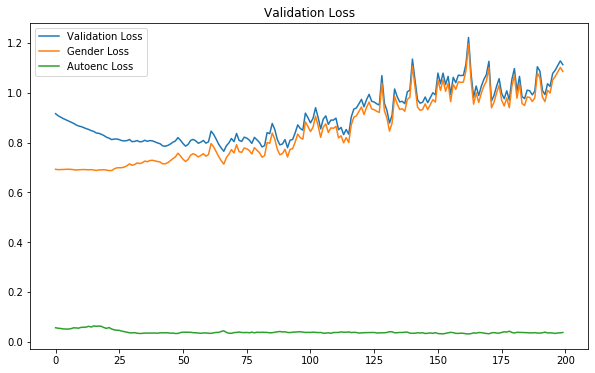

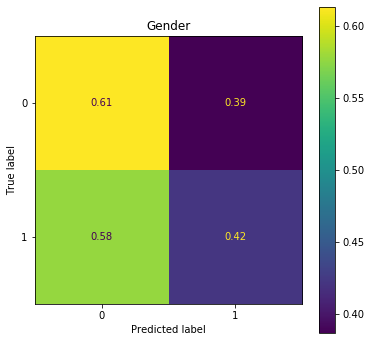

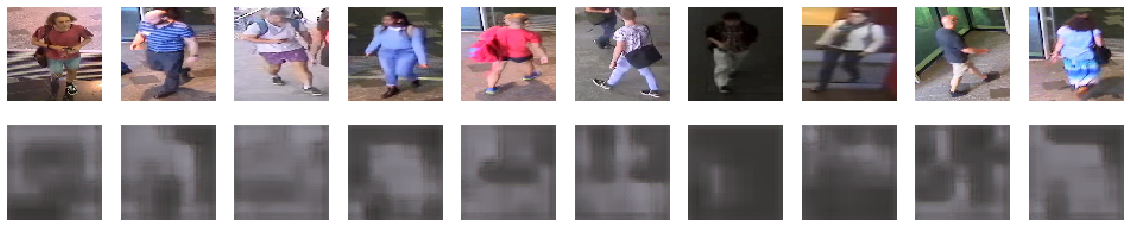

In [39]:
input_img = Input(shape=(80, 80, 3))

conv1 = Conv2D(16, (3, 3), activation=None, padding='same')(input_img)
conv1 = BatchNormalization()(conv1)
conv1 = Activation('relu')(conv1)
conv1 = SpatialDropout2D(0.2)(conv1)
pool1 = MaxPooling2D((4, 4), padding='same')(conv1)

conv2 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool1)
conv2 = BatchNormalization()(conv2)
conv2 = Activation('relu')(conv2)
conv2 = SpatialDropout2D(0.2)(conv2)
pool2 = MaxPooling2D((2, 2), padding='same')(conv2)

conv3 = Conv2D(4, (3, 3), activation=None, padding='same')(pool2)
conv3 = BatchNormalization()(conv3)
conv3 = Activation('relu')(conv3)
conv3 = SpatialDropout2D(0.2)(conv3)

encoded = MaxPooling2D((2, 2), padding='same', name='bottleneck')(conv3)

# Autoencoder Output
conv4 = Conv2D(4, (3, 3), activation=None, padding='same')(encoded)
conv4 = BatchNormalization()(conv4)
conv4 = Activation('relu')(conv4)
conv4 = SpatialDropout2D(0.2)(conv4)
up1 = UpSampling2D((4, 4))(conv4)

conv5 = Conv2D(8, (3, 3), activation=None, padding='same')(up1)
conv5 = BatchNormalization()(conv5)
conv5 = Activation('relu')(conv5)
conv5 = SpatialDropout2D(0.2)(conv5)
up2 = UpSampling2D((2, 2))(conv5)

conv6 = Conv2D(16, (3, 3), activation=None, padding='same')(up2)
conv6 = BatchNormalization()(conv6)
conv6 = Activation('relu')(conv6)
conv6 = SpatialDropout2D(0.2)(conv6)
up3 = UpSampling2D((2, 2))(conv6)

decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same', name='autoenc_output')(up3)

flatten = Flatten()(encoded)

# gender Output
gender_out = Dense(32, activation=None)(flatten)
gender_out = BatchNormalization()(gender_out)
gender_out = Activation('relu')(gender_out)
gender_out = Dropout(0.2)(gender_out)
gender_out = Dense(16, activation=None, kernel_regularizer='l2')(gender_out)
gender_out = BatchNormalization()(gender_out)
gender_out = Activation('relu')(gender_out)
gender_out = Dropout(0.2)(gender_out)
gender_out = Dense(2, activation='softmax', name='gender_output')(gender_out)

multitask_cnn = Model(input_img, [gender_out, decoded])

multitask_cnn.compile(optimizer='adam', loss=[masked_cce, 'mean_squared_error'], loss_weights=[1, 0.5])

print(multitask_cnn.summary())

# plot_model(multitask_cnn, show_shapes=True)

history = multitask_cnn.fit(X_train, [y_train_gender, X_train],
                    batch_size=32,
                    epochs=200,
                    validation_data=(X_test, [y_test_gender, X_test]), verbose=0)

eval_model(multitask_cnn, X_test, y_test_gender, history, 2)

## Network with Multiple Outputs

In [15]:
def eval_model(model, x_test, y_test1, y_test2, y_test3, y_test4, y_test5, y_test6, history):
    pred_gender, pred_tortyp, pred_torcol, pred_legtyp, pred_legcol, pred_luggage, decoded_imgs = model.predict(x_test);

    fig = plt.figure(figsize=[10, 6])
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(history.history['loss'], label="Training Loss")
    ax.plot(history.history['gender_output_loss'], label="Gender Loss")
    ax.plot(history.history['tortyp_output_loss'], label="Tortyp Loss")
    ax.plot(history.history['torcol_output_loss'], label="Torcol Loss")
    ax.plot(history.history['legtyp_output_loss'], label="Legtyp Loss")
    ax.plot(history.history['legcol_output_loss'], label="Legcol Loss")
    ax.plot(history.history['luggage_output_loss'], label="Luggage Loss")
    ax.plot(history.history['autoenc_output_loss'], label="Autoencoder Loss")
    ax.legend()
    ax.set_title('Training Loss')

    fig = plt.figure(figsize=[10, 6])
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(history.history['val_loss'], label="Validation Loss")
    ax.plot(history.history['val_gender_output_loss'], label="Gender Loss")
    ax.plot(history.history['val_tortyp_output_loss'], label="Tortyp Loss")
    ax.plot(history.history['val_torcol_output_loss'], label="Torcol Loss")
    ax.plot(history.history['val_legtyp_output_loss'], label="Legtyp Loss")
    ax.plot(history.history['val_legcol_output_loss'], label="Legcol Loss")
    ax.plot(history.history['val_luggage_output_loss'], label="Luggage Loss")
    ax.plot(history.history['val_autoenc_output_loss'], label="Autoencoder Loss")
    ax.legend()
    ax.set_title('Validation Loss')

    fig = plt.figure(figsize=[22, 12])

    indexes = tf.argmax(pred_gender, axis=1)
    gt = tf.argmax(y_test1, axis=1)
    cm = confusion_matrix(gt, indexes, labels=range(2), normalize='true')
    ax = fig.add_subplot(2, 3, 1)
    c = ConfusionMatrixDisplay(cm,display_labels=range(2))
    c.plot(ax = ax)
    ax.set_title('Gender')

    indexes = tf.argmax(pred_tortyp, axis=1)
    gt = tf.argmax(y_test2, axis=1)
    cm = confusion_matrix(gt, indexes, labels=range(2), normalize='true')
    ax = fig.add_subplot(2, 3, 2)
    c = ConfusionMatrixDisplay(cm,display_labels=range(2))
    c.plot(ax = ax)
    ax.set_title('Tortyp')

    indexes = tf.argmax(pred_torcol, axis=1)
    gt = tf.argmax(y_test3, axis=1)
    cm = confusion_matrix(gt, indexes, labels=range(11), normalize='true')
    ax = fig.add_subplot(2, 3, 3)
    c = ConfusionMatrixDisplay(cm, display_labels=range(11))
    c.plot(ax = ax)
    ax.set_title('Torcol')

    indexes = tf.argmax(pred_legtyp, axis=1)
    gt = tf.argmax(y_test4, axis=1)
    cm = confusion_matrix(gt, indexes, labels=range(2), normalize='true')
    ax = fig.add_subplot(2, 3, 4)
    c = ConfusionMatrixDisplay(cm, display_labels=range(2))
    c.plot(ax = ax)
    ax.set_title('Legtyp')

    indexes = tf.argmax(pred_legcol, axis=1)
    gt = tf.argmax(y_test5, axis=1)
    cm = confusion_matrix(gt, indexes, labels=range(11), normalize='true')
    ax = fig.add_subplot(2, 3, 5)
    c = ConfusionMatrixDisplay(cm, display_labels=range(11))
    c.plot(ax = ax)
    ax.set_title('Legcol')

    indexes = tf.argmax(pred_luggage, axis=1)
    gt = tf.argmax(y_test6, axis=1)
    cm = confusion_matrix(gt, indexes, labels=range(2), normalize='true')
    ax = fig.add_subplot(2, 3, 6)
    c = ConfusionMatrixDisplay(cm, display_labels=range(2))
    c.plot(ax = ax)
    ax.set_title('Luggage')

    n = 10
    fig = plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i+1)
        ax.imshow(x_test[i])
        ax.set_axis_off()

        # display reconstruction
        ax = plt.subplot(2, n, i + n + 1)
        ax.imshow(decoded_imgs[i])
        ax.set_axis_off()

In [70]:
input_img = Input(shape=(80, 80, 3))

conv1 = Conv2D(16, (3, 3), activation=None, padding='same')(input_img)
conv1 = BatchNormalization()(conv1)
conv1 = Activation('relu')(conv1)
conv1 = SpatialDropout2D(0.2)(conv1)
pool1 = MaxPooling2D((4, 4), padding='same')(conv1)

conv2 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool1)
conv2 = BatchNormalization()(conv2)
conv2 = Activation('relu')(conv2)
conv2 = SpatialDropout2D(0.2)(conv2)
pool2 = MaxPooling2D((2, 2), padding='same')(conv2)

conv3 = Conv2D(4, (3, 3), activation=None, padding='same')(pool2)
conv3 = BatchNormalization()(conv3)
conv3 = Activation('relu')(conv3)
conv3 = SpatialDropout2D(0.2)(conv3)

encoded = MaxPooling2D((2, 2), padding='same', name='bottleneck')(conv3)

# Autoencoder Output
conv4 = Conv2D(4, (3, 3), activation=None, padding='same')(encoded)
conv4 = BatchNormalization()(conv4)
conv4 = Activation('relu')(conv4)
conv4 = SpatialDropout2D(0.2)(conv4)
up1 = UpSampling2D((4, 4))(conv4)

conv5 = Conv2D(8, (3, 3), activation=None, padding='same')(up1)
conv5 = BatchNormalization()(conv5)
conv5 = Activation('relu')(conv5)
conv5 = SpatialDropout2D(0.2)(conv5)
up2 = UpSampling2D((2, 2))(conv5)

conv6 = Conv2D(16, (3, 3), activation=None, padding='same')(up2)
conv6 = BatchNormalization()(conv6)
conv6 = Activation('relu')(conv6)
conv6 = SpatialDropout2D(0.2)(conv6)
up3 = UpSampling2D((2, 2))(conv6)

decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same', name='autoenc_output')(up3)

flatten = Flatten()(encoded)

# gender Output
gender_out = Dense(32, activation=None)(flatten)
gender_out = BatchNormalization()(gender_out)
gender_out = Activation('relu')(gender_out)
gender_out = Dropout(0.2)(gender_out)
gender_out = Dense(16, activation=None, kernel_regularizer='l2')(gender_out)
gender_out = BatchNormalization()(gender_out)
gender_out = Activation('relu')(gender_out)
gender_out = Dropout(0.2)(gender_out)
gender_out = Dense(2, activation='softmax', name='gender_output')(gender_out)

# tortyp Output
tortyp_out = Dense(32, activation=None)(flatten)
tortyp_out = BatchNormalization()(tortyp_out)
tortyp_out = Activation('relu')(tortyp_out)
tortyp_out = Dropout(0.2)(tortyp_out)
tortyp_out = Dense(16, activation=None, kernel_regularizer='l2')(tortyp_out)
tortyp_out = BatchNormalization()(tortyp_out)
tortyp_out = Activation('relu')(tortyp_out)
tortyp_out = Dropout(0.2)(tortyp_out)
tortyp_out = Dense(2, activation='softmax', name='tortyp_output')(tortyp_out)

# torcol Output
torcol_out = Dense(32, activation=None)(flatten)
torcol_out = BatchNormalization()(torcol_out)
torcol_out = Activation('relu')(torcol_out)
torcol_out = Dropout(0.2)(torcol_out)
torcol_out = Dense(16, activation=None, kernel_regularizer='l2')(torcol_out)
torcol_out = BatchNormalization()(torcol_out)
torcol_out = Activation('relu')(torcol_out)
torcol_out = Dropout(0.2)(torcol_out)
torcol_out = Dense(11, activation='softmax', name='torcol_output')(torcol_out)

# legtyp Output
legtyp_out = Dense(32, activation=None)(flatten)
legtyp_out = BatchNormalization()(legtyp_out)
legtyp_out = Activation('relu')(legtyp_out)
legtyp_out = Dropout(0.2)(legtyp_out)
legtyp_out = Dense(16, activation=None, kernel_regularizer='l2')(legtyp_out)
legtyp_out = BatchNormalization()(legtyp_out)
legtyp_out = Activation('relu')(legtyp_out)
legtyp_out = Dropout(0.2)(legtyp_out)
legtyp_out = Dense(2, activation='softmax', name='legtyp_output')(legtyp_out)

# legcol Output
legcol_out = Dense(32, activation=None)(flatten)
legcol_out = BatchNormalization()(legcol_out)
legcol_out = Activation('relu')(legcol_out)
legcol_out = Dropout(0.2)(legcol_out)
legcol_out = Dense(16, activation=None, kernel_regularizer='l2')(legcol_out)
legcol_out = BatchNormalization()(legcol_out)
legcol_out = Activation('relu')(legcol_out)
legcol_out = Dropout(0.2)(legcol_out)
legcol_out = Dense(11, activation='softmax', name='legcol_output')(legcol_out)

# luggage Output
luggage_out = Dense(32, activation=None)(flatten)
luggage_out = BatchNormalization()(luggage_out)
luggage_out = Activation('relu')(luggage_out)
luggage_out = Dropout(0.2)(luggage_out)
luggage_out = Dense(16, activation=None, kernel_regularizer='l2')(luggage_out)
luggage_out = BatchNormalization()(luggage_out)
luggage_out = Activation('relu')(luggage_out)
luggage_out = Dropout(0.2)(luggage_out)
luggage_out = Dense(2, activation='softmax', name='luggage_output')(luggage_out)

multitask_cnn = Model(input_img, [gender_out, tortyp_out, torcol_out, legtyp_out, legcol_out, luggage_out, decoded])

multitask_cnn.compile(optimizer='adam', loss=[masked_cce, masked_cce, masked_cce, masked_cce, masked_cce, masked_cce, 'mean_squared_error'], loss_weights=[1, 1, 1, 1, 1, 1, 0.5])

print(multitask_cnn.summary())

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 80, 80, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_81 (Conv2D)              (None, 80, 80, 16)   448         input_15[0][0]                   
__________________________________________________________________________________________________
batch_normalization_83 (BatchNo (None, 80, 80, 16)   64          conv2d_81[0][0]                  
__________________________________________________________________________________________________
activation_83 (Activation)      (None, 80, 80, 16)   0           batch_normalization_83[0][0]     
___________________________________________________________________________________________

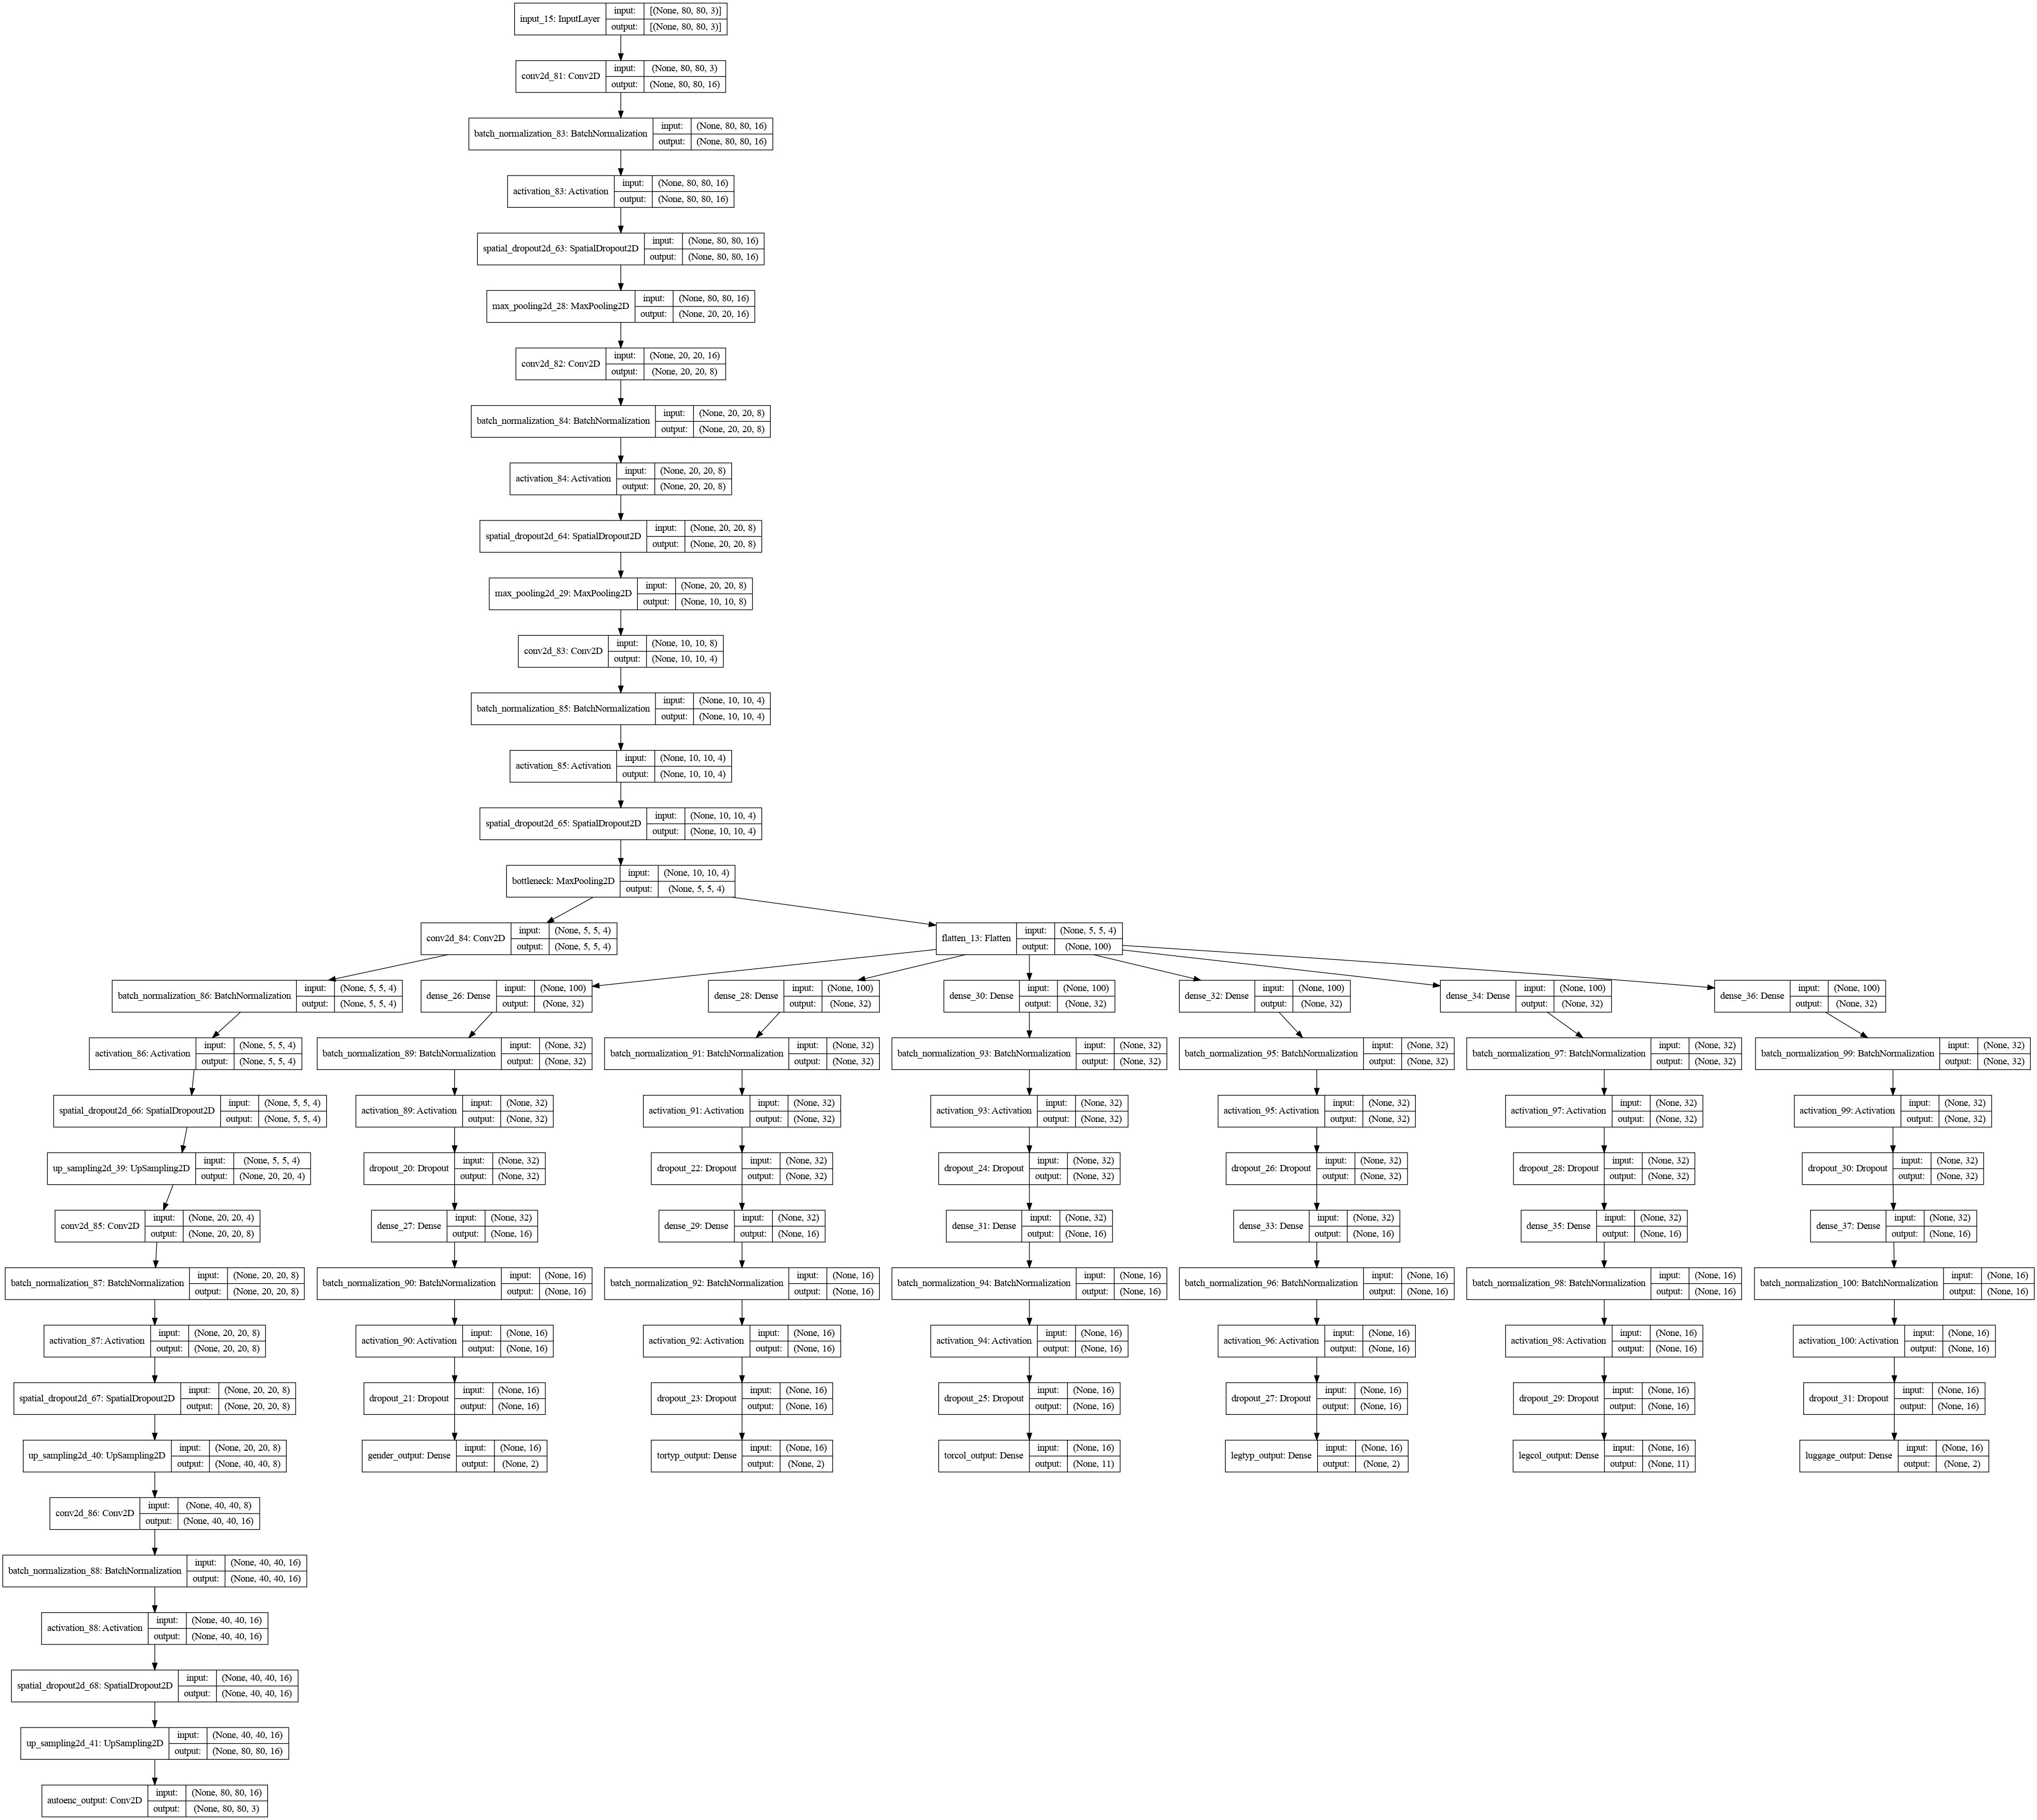

In [71]:
plot_model(multitask_cnn, to_file='test_keras_plot_model.png', show_shapes=True)
IPython.display.Image('test_keras_plot_model.png')

In [72]:
history = multitask_cnn.fit(X_train, [y_train_gender, y_train_tortyp, y_train_torcol, y_train_legtyp, y_train_legcol, y_train_luggage, X_train],
                    batch_size=32,
                    epochs=250,
                    validation_data=(X_test, [y_test_gender, y_test_tortyp, y_test_torcol, y_test_legtyp, y_test_legcol, y_test_luggage, X_test]), verbose=0)

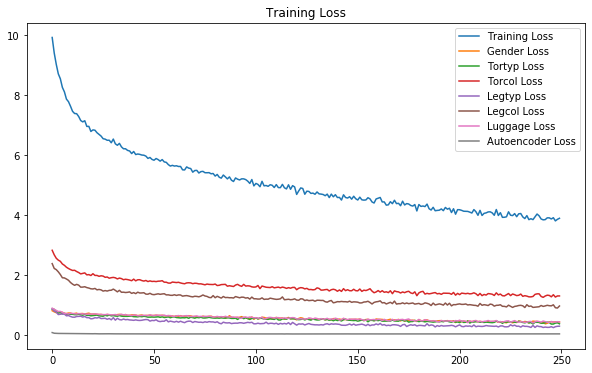

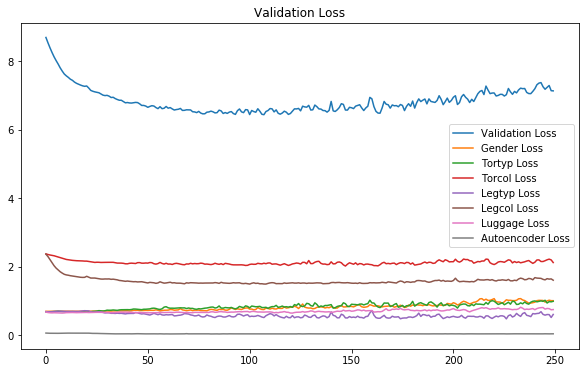

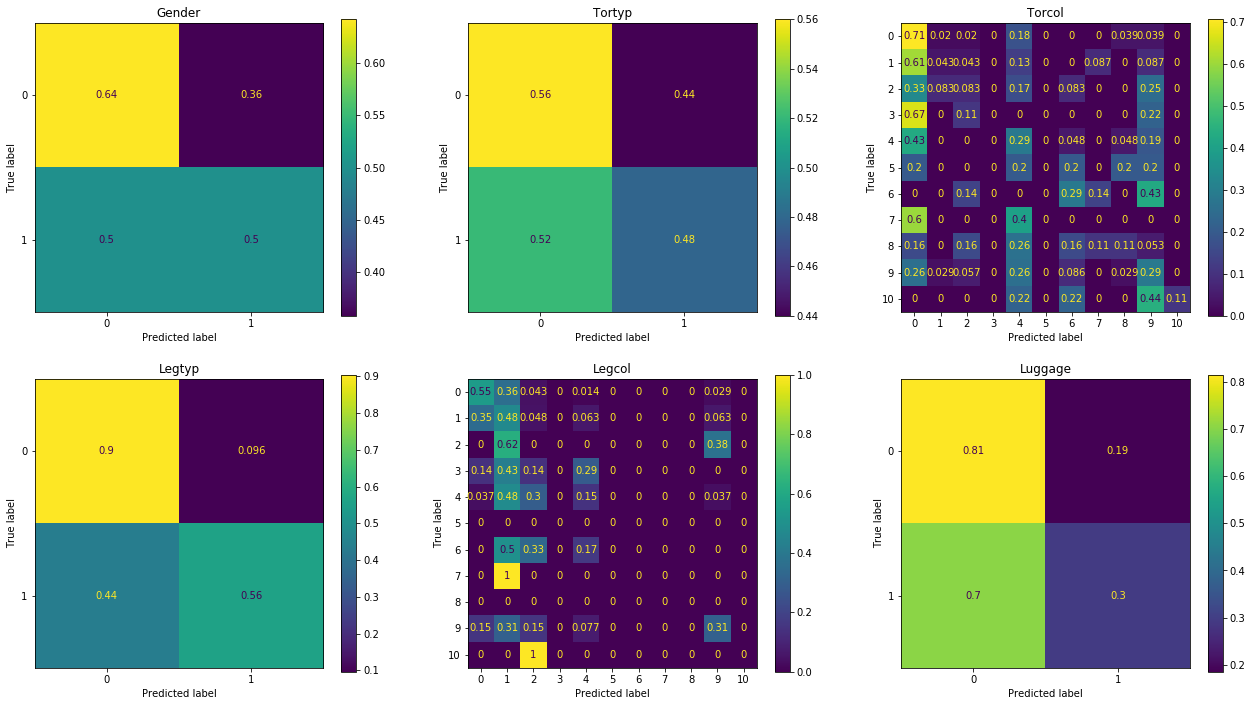

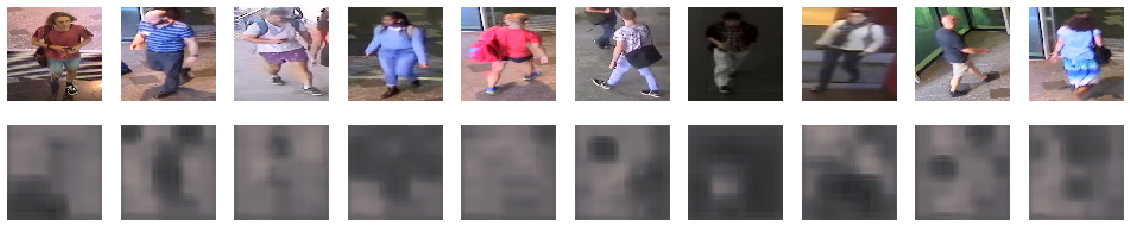

In [75]:
eval_model(multitask_cnn, X_test, y_test_gender, y_test_tortyp, y_test_torcol, y_test_legtyp, y_test_legcol, y_test_luggage, history)

## Data Augmentation

Let's add Batch nomalization, Dropout and data augmentation

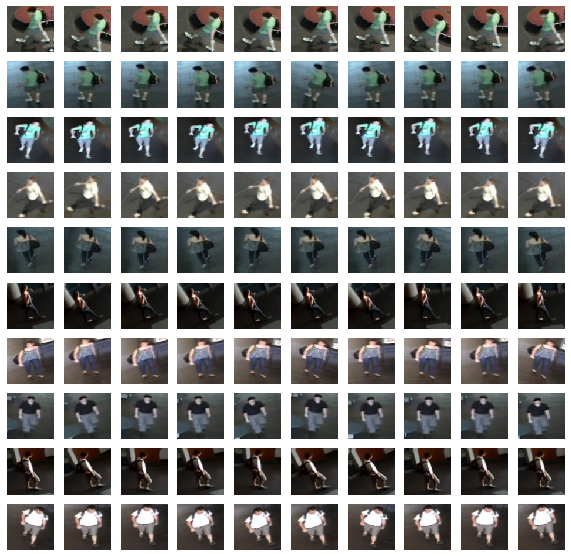

In [16]:
data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomRotation(0.05),
    layers.experimental.preprocessing.RandomZoom(height_factor=(-0.025, 0.025)),
    layers.experimental.preprocessing.RandomTranslation(height_factor=(0.05), width_factor=(0.05))
])

fig = plt.figure(figsize=[10, 10])
for i in range(10):
    for j in range(10):
        ax = fig.add_subplot(10, 10, i*10 + (j + 1))
        augmented_image = data_augmentation(tf.expand_dims(X_train[i,:,:,:],0))
        plt.imshow(augmented_image[0])
        plt.axis("off")

In [17]:
input_img = Input(shape=(80, 80, 3))

augmenter = data_augmentation(input_img)

conv1 = Conv2D(16, (3, 3), activation=None, padding='same')(input_img)
conv1 = BatchNormalization()(conv1)
conv1 = Activation('relu')(conv1)
conv1 = SpatialDropout2D(0.2)(conv1)
pool1 = MaxPooling2D((4, 4), padding='same')(conv1)

conv2 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool1)
conv2 = BatchNormalization()(conv2)
conv2 = Activation('relu')(conv2)
conv2 = SpatialDropout2D(0.2)(conv2)
pool2 = MaxPooling2D((2, 2), padding='same')(conv2)

conv3 = Conv2D(4, (3, 3), activation=None, padding='same')(pool2)
conv3 = BatchNormalization()(conv3)
conv3 = Activation('relu')(conv3)
conv3 = SpatialDropout2D(0.2)(conv3)

encoded = MaxPooling2D((2, 2), padding='same', name='bottleneck')(conv3)

# Autoencoder Output
conv4 = Conv2D(4, (3, 3), activation=None, padding='same')(encoded)
conv4 = BatchNormalization()(conv4)
conv4 = Activation('relu')(conv4)
conv4 = SpatialDropout2D(0.2)(conv4)
up1 = UpSampling2D((4, 4))(conv4)

conv5 = Conv2D(8, (3, 3), activation=None, padding='same')(up1)
conv5 = BatchNormalization()(conv5)
conv5 = Activation('relu')(conv5)
conv5 = SpatialDropout2D(0.2)(conv5)
up2 = UpSampling2D((2, 2))(conv5)

conv6 = Conv2D(16, (3, 3), activation=None, padding='same')(up2)
conv6 = BatchNormalization()(conv6)
conv6 = Activation('relu')(conv6)
conv6 = SpatialDropout2D(0.2)(conv6)
up3 = UpSampling2D((2, 2))(conv6)

decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same', name='autoenc_output')(up3)

flatten = Flatten()(encoded)

# gender Output
gender_out = Dense(32, activation=None)(flatten)
gender_out = BatchNormalization()(gender_out)
gender_out = Activation('relu')(gender_out)
gender_out = Dropout(0.2)(gender_out)
gender_out = Dense(16, activation=None, kernel_regularizer='l2')(gender_out)
gender_out = BatchNormalization()(gender_out)
gender_out = Activation('relu')(gender_out)
gender_out = Dropout(0.2)(gender_out)
gender_out = Dense(2, activation='softmax', name='gender_output')(gender_out)

# tortyp Output
tortyp_out = Dense(32, activation=None)(flatten)
tortyp_out = BatchNormalization()(tortyp_out)
tortyp_out = Activation('relu')(tortyp_out)
tortyp_out = Dropout(0.2)(tortyp_out)
tortyp_out = Dense(16, activation=None, kernel_regularizer='l2')(tortyp_out)
tortyp_out = BatchNormalization()(tortyp_out)
tortyp_out = Activation('relu')(tortyp_out)
tortyp_out = Dropout(0.2)(tortyp_out)
tortyp_out = Dense(2, activation='softmax', name='tortyp_output')(tortyp_out)

# torcol Output
torcol_out = Dense(32, activation=None)(flatten)
torcol_out = BatchNormalization()(torcol_out)
torcol_out = Activation('relu')(torcol_out)
torcol_out = Dropout(0.2)(torcol_out)
torcol_out = Dense(16, activation=None, kernel_regularizer='l2')(torcol_out)
torcol_out = BatchNormalization()(torcol_out)
torcol_out = Activation('relu')(torcol_out)
torcol_out = Dropout(0.2)(torcol_out)
torcol_out = Dense(11, activation='softmax', name='torcol_output')(torcol_out)

# legtyp Output
legtyp_out = Dense(32, activation=None)(flatten)
legtyp_out = BatchNormalization()(legtyp_out)
legtyp_out = Activation('relu')(legtyp_out)
legtyp_out = Dropout(0.2)(legtyp_out)
legtyp_out = Dense(16, activation=None, kernel_regularizer='l2')(legtyp_out)
legtyp_out = BatchNormalization()(legtyp_out)
legtyp_out = Activation('relu')(legtyp_out)
legtyp_out = Dropout(0.2)(legtyp_out)
legtyp_out = Dense(2, activation='softmax', name='legtyp_output')(legtyp_out)

# legcol Output
legcol_out = Dense(32, activation=None)(flatten)
legcol_out = BatchNormalization()(legcol_out)
legcol_out = Activation('relu')(legcol_out)
legcol_out = Dropout(0.2)(legcol_out)
legcol_out = Dense(16, activation=None, kernel_regularizer='l2')(legcol_out)
legcol_out = BatchNormalization()(legcol_out)
legcol_out = Activation('relu')(legcol_out)
legcol_out = Dropout(0.2)(legcol_out)
legcol_out = Dense(11, activation='softmax', name='legcol_output')(legcol_out)

# luggage Output
luggage_out = Dense(32, activation=None)(flatten)
luggage_out = BatchNormalization()(luggage_out)
luggage_out = Activation('relu')(luggage_out)
luggage_out = Dropout(0.2)(luggage_out)
luggage_out = Dense(16, activation=None, kernel_regularizer='l2')(luggage_out)
luggage_out = BatchNormalization()(luggage_out)
luggage_out = Activation('relu')(luggage_out)
luggage_out = Dropout(0.2)(luggage_out)
luggage_out = Dense(2, activation='softmax', name='luggage_output')(luggage_out)

multitask_cnn = Model(input_img, [gender_out, tortyp_out, torcol_out, legtyp_out, legcol_out, luggage_out, decoded])

multitask_cnn.compile(optimizer='adam', loss=[masked_cce, masked_cce, masked_cce, masked_cce, masked_cce, masked_cce, 'mean_squared_error'], loss_weights=[1, 1, 1, 1, 1, 1, 0.5])

print(multitask_cnn.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80, 80, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 80, 80, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 80, 80, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 80, 80, 16)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

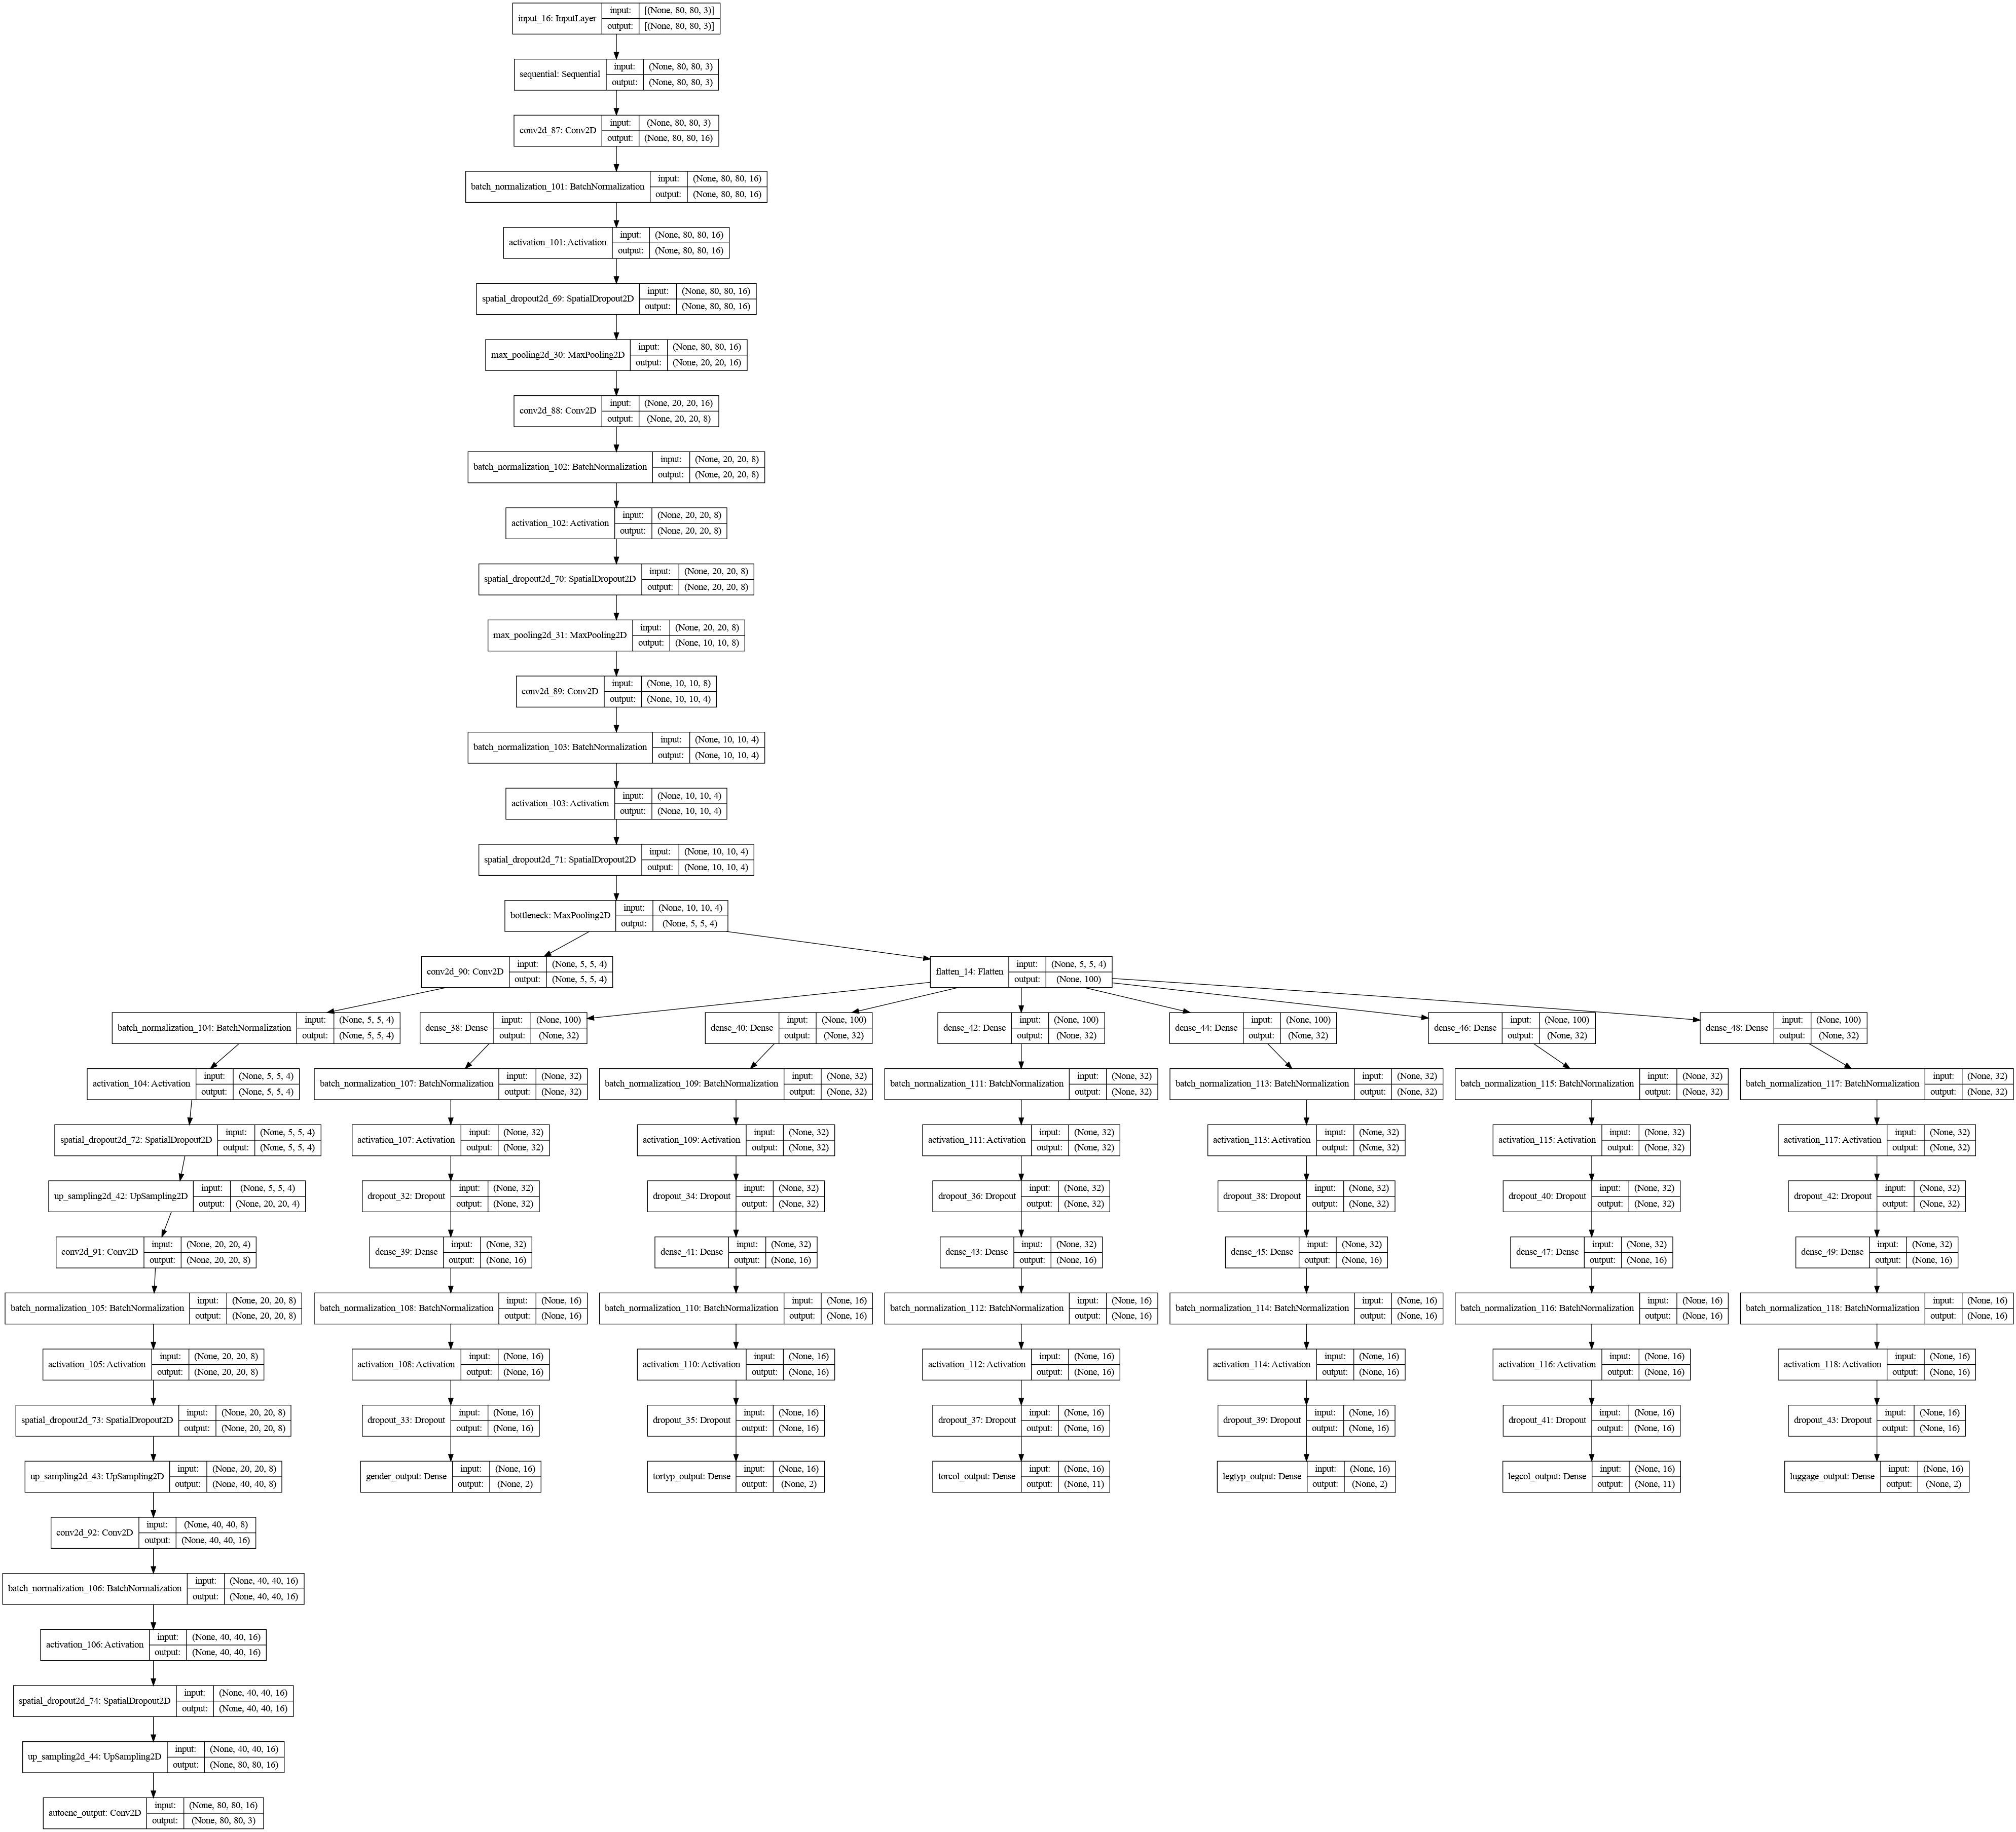

In [78]:
plot_model(multitask_cnn, to_file='test_keras_plot_model.png', show_shapes=True)
IPython.display.Image('test_keras_plot_model.png')

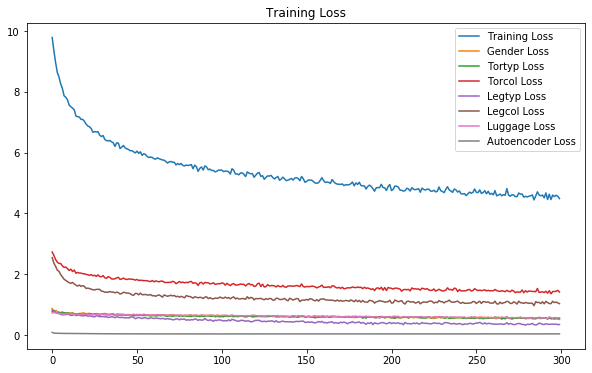

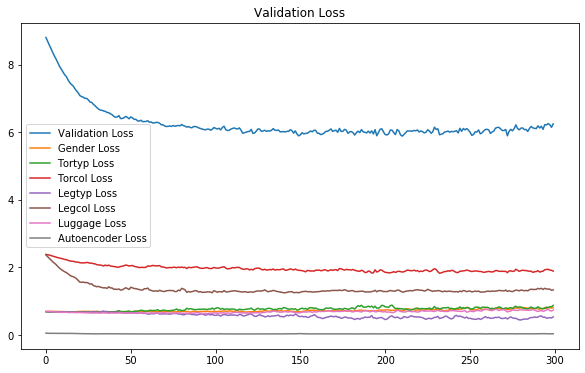

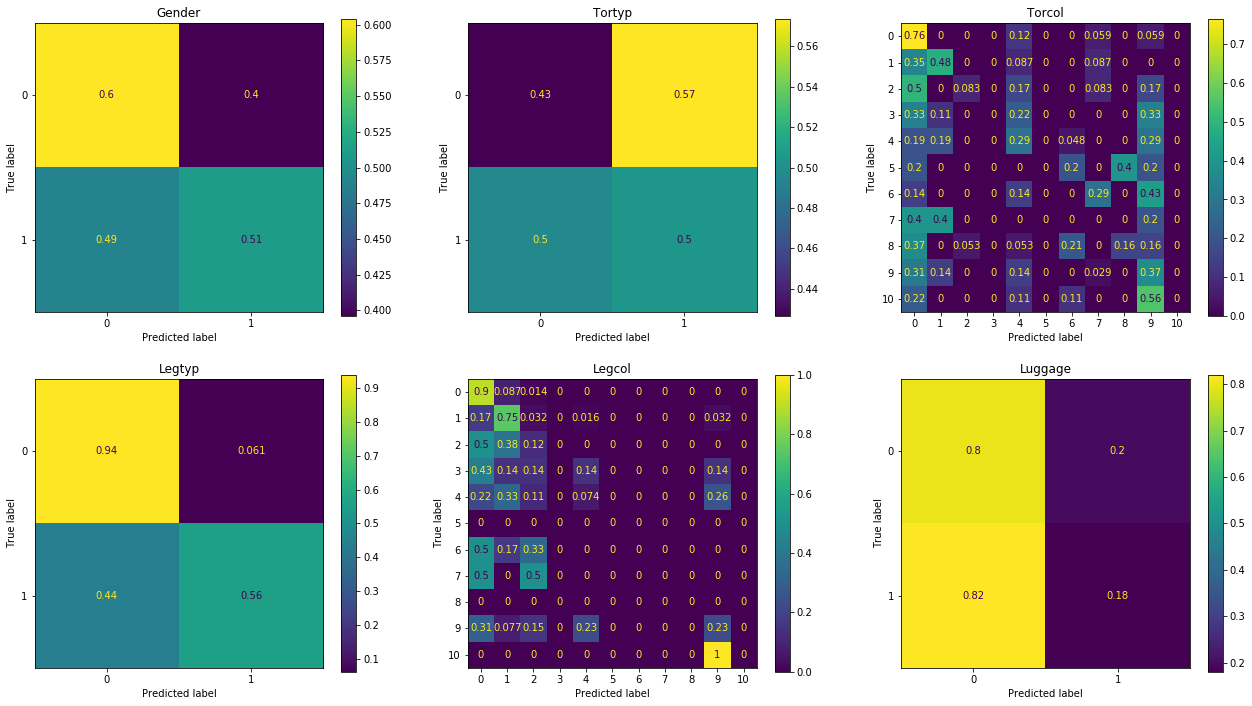

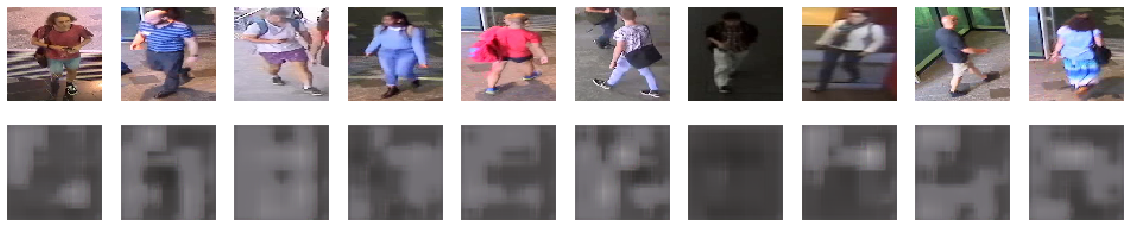

In [79]:
history = multitask_cnn.fit(X_train, [y_train_gender, y_train_tortyp, y_train_torcol, y_train_legtyp, y_train_legcol, y_train_luggage, X_train],
                    batch_size=32,
                    epochs=300,
                    validation_data=(X_test, [y_test_gender, y_test_tortyp, y_test_torcol, y_test_legtyp, y_test_legcol, y_test_luggage, X_test]), verbose=0)

eval_model(multitask_cnn, X_test, y_test_gender, y_test_tortyp, y_test_torcol, y_test_legtyp, y_test_legcol, y_test_luggage, history)

## Segmentation Model

In [28]:
# input, colour images
input_img = Input(shape=(80, 80, 3))

# encoder, add more filters as we go deeper
x = Conv2D(16, (5, 5), activation='relu', padding='same')(input_img)
x = MaxPooling2D((4, 4), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

# decoder, reduce filters as we go back up
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((4, 4))(x)

# output, 9 channels for 9 classes
decoded = Conv2D(9, (1, 1), activation='softmax', padding='same')(x)

segmenter = Model(input_img, decoded)
# loss is categorical_crossentropy, this will be calculated per-pixel and averaged
segmenter.compile(optimizer='adam', loss='categorical_crossentropy')
print(segmenter.summary())

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 80, 80, 3)]       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 80, 80, 16)        1216      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 20, 20, 16)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 20, 20, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 10, 10, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 5, 5, 64)          0   

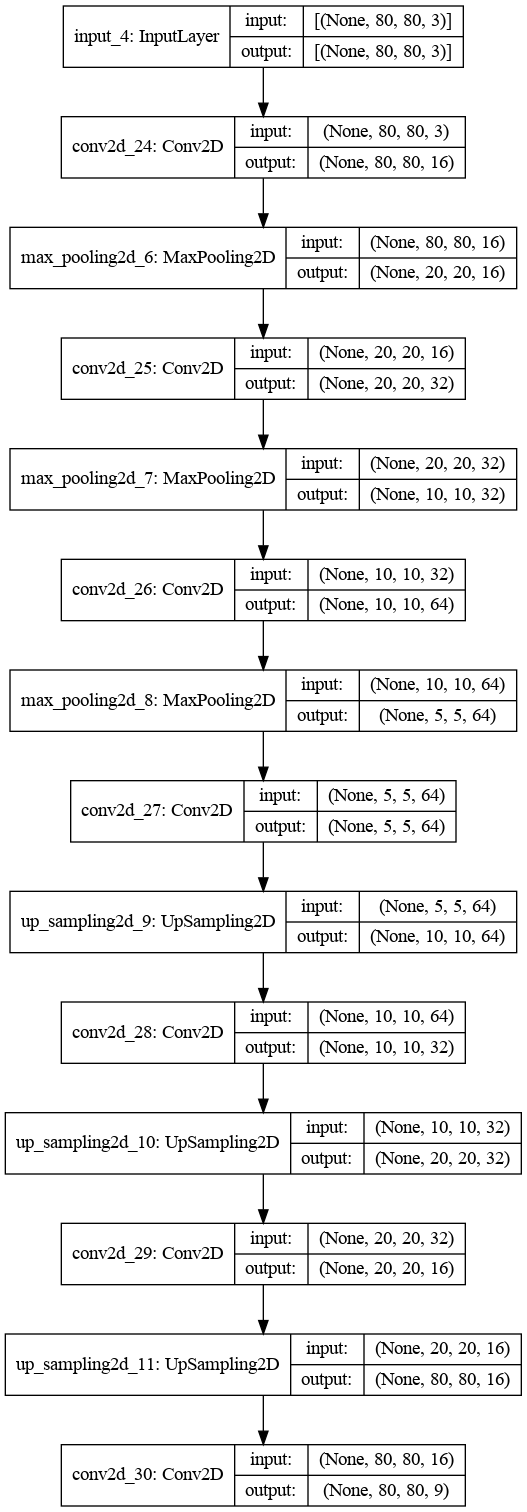

In [29]:
plot_model(segmenter, to_file='test_keras_plot_model.png', show_shapes=True)
IPython.display.Image('test_keras_plot_model.png')

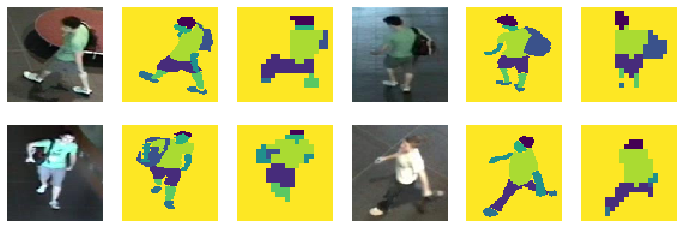

In [30]:
segmenter.fit(X_train, X_train_mask_categorical, batch_size=32, epochs=100, validation_split=0.2, verbose=0)

prediction_basic = segmenter.predict(X_train)

fig = plt.figure(figsize=[12, 4])
for i in range(4):
    ax = fig.add_subplot(2, 6, 3*i+1)
    ax.imshow(X_train[i,:,:,:])
    ax.set_axis_off()
    ax = fig.add_subplot(2, 6, 3*i+2)
    ax.imshow(categorical_to_mask(X_train_mask_categorical[i,:,:,:]))
    ax.set_axis_off()
    ax = fig.add_subplot(2, 6, 3*i+3)
    ax.imshow(categorical_to_mask(prediction_basic[i,:,:,:]))
    ax.set_axis_off()

### U-net

In [31]:
input_img = Input(shape=(80, 80, 3))

conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D((2, 2), padding='same')(conv1)

conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D((2, 2), padding='same')(conv2)

conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D((2, 2), padding='same')(conv3)

conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4)

up1 = UpSampling2D((2, 2))(conv4)
merge1 = concatenate([conv3,up1], axis = 3)
conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge1)
conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5)

up2 = UpSampling2D((2, 2))(conv5)
merge2 = concatenate([conv2,up2], axis = 3)
conv6 = Conv2D(32, (3, 3), activation='relu', padding='same')(merge2)
conv6 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv6)

up3 = UpSampling2D((2, 2))(conv6)
merge3 = concatenate([conv1,up3], axis = 3)
conv7 = Conv2D(16, (3, 3), activation='relu', padding='same')(merge3)
conv7 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv7)
decoded = Conv2D(9, (1, 1), activation='softmax', padding='same')(conv7)

segmenter = Model(input_img, decoded)
segmenter.compile(optimizer='adam', loss='categorical_crossentropy')
print(segmenter.summary())

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 80, 80, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 80, 80, 16)   448         input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_32 (Conv2D)              (None, 80, 80, 16)   2320        conv2d_31[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 40, 40, 16)   0           conv2d_32[0][0]                  
____________________________________________________________________________________________

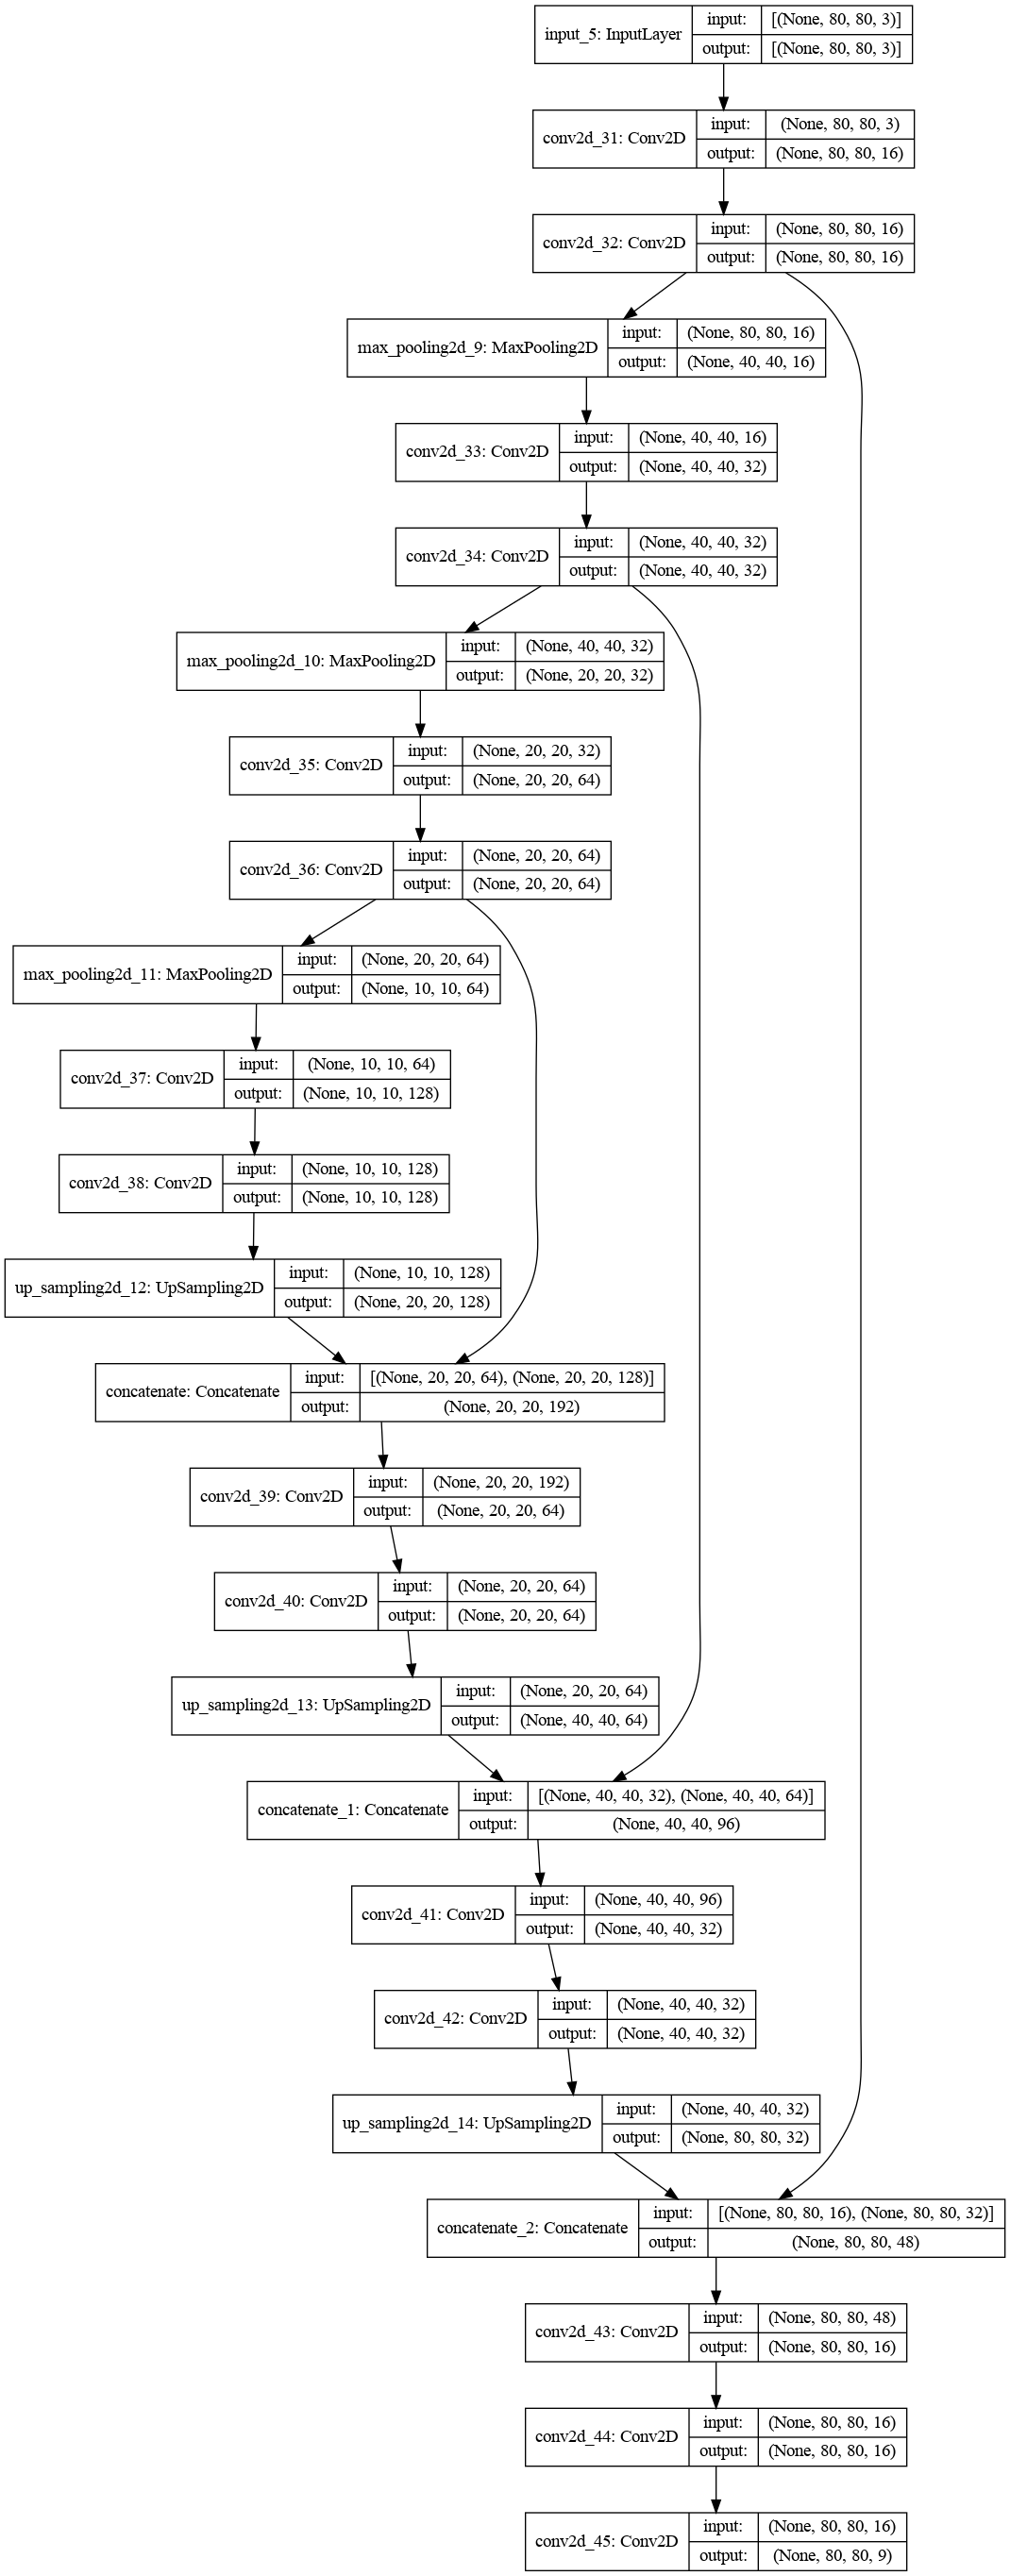

In [32]:
plot_model(segmenter, to_file='test_keras_plot_model.png', show_shapes=True)
IPython.display.Image('test_keras_plot_model.png')

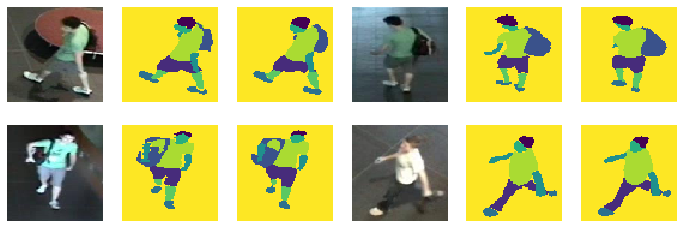

In [33]:
segmenter.fit(X_train, X_train_mask_categorical, batch_size=32, epochs=100, validation_split=0.2, verbose=0)

prediction_unet = segmenter.predict(X_train)

fig = plt.figure(figsize=[12, 4])
for i in range(4):
    ax = fig.add_subplot(2, 6, 3*i+1)
    ax.imshow(X_train[i,:,:,:])
    ax.set_axis_off()
    ax = fig.add_subplot(2, 6, 3*i+2)
    ax.imshow(categorical_to_mask(X_train_mask_categorical[i,:,:,:]))
    ax.set_axis_off()
    ax = fig.add_subplot(2, 6, 3*i+3)
    ax.imshow(categorical_to_mask(prediction_unet[i,:,:,:]))
    ax.set_axis_off()

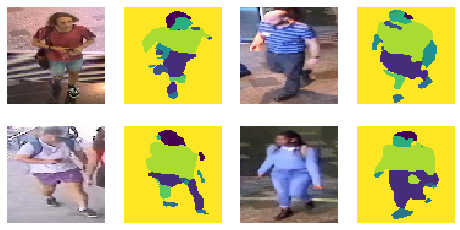

In [42]:
prediction_unet = segmenter.predict(X_test)
    
fig = plt.figure(figsize=[8, 4])
for i in range(4):
    ax = fig.add_subplot(2, 4, 2*i+1)
    ax.imshow(X_test[i,:,:,:])
    ax.set_axis_off()
    ax = fig.add_subplot(2, 4, 2*i+2)
    ax.imshow(categorical_to_mask(prediction_unet[i,:,:,:]))
    ax.set_axis_off()

## Multiple Outputs Network + Segmentation Task

In [80]:
input_img = Input(shape=(80, 80, 3))

conv1 = Conv2D(8, (3, 3), activation='relu', padding='same')(input_img)
conv1 = Conv2D(8, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D((2, 2), padding='same')(conv1)

conv2 = Conv2D(16, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D((2, 2), padding='same')(conv2)

conv3 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv3)

encoded = MaxPooling2D((2, 2), padding='same')(conv3)

# Segmentation Output
conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)

up1 = UpSampling2D((2, 2))(conv4)
merge1 = concatenate([conv3,up1], axis = 3)
conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(merge1)
conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv5)

up2 = UpSampling2D((2, 2))(conv5)
merge2 = concatenate([conv2,up2], axis = 3)
conv6 = Conv2D(16, (3, 3), activation='relu', padding='same')(merge2)
conv6 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv6)

up3 = UpSampling2D((2, 2))(conv6)
merge3 = concatenate([conv1,up3], axis = 3)
conv7 = Conv2D(8, (3, 3), activation='relu', padding='same')(merge3)
conv7 = Conv2D(8, (3, 3), activation='relu', padding='same')(conv7)
decoded = Conv2D(9, (1, 1), activation='softmax', padding='same', name='seg_output')(conv7)

flatten = Flatten()(encoded)

# gender Output
gender_out = Dense(32, activation=None)(flatten)
gender_out = BatchNormalization()(gender_out)
gender_out = Activation('relu')(gender_out)
gender_out = Dropout(0.2)(gender_out)
gender_out = Dense(16, activation=None, kernel_regularizer='l2')(gender_out)
gender_out = BatchNormalization()(gender_out)
gender_out = Activation('relu')(gender_out)
gender_out = Dropout(0.2)(gender_out)
gender_out = Dense(2, activation='softmax', name='gender_output')(gender_out)

# tortyp Output
tortyp_out = Dense(32, activation=None)(flatten)
tortyp_out = BatchNormalization()(tortyp_out)
tortyp_out = Activation('relu')(tortyp_out)
tortyp_out = Dropout(0.2)(tortyp_out)
tortyp_out = Dense(16, activation=None, kernel_regularizer='l2')(tortyp_out)
tortyp_out = BatchNormalization()(tortyp_out)
tortyp_out = Activation('relu')(tortyp_out)
tortyp_out = Dropout(0.2)(tortyp_out)
tortyp_out = Dense(2, activation='softmax', name='tortyp_output')(tortyp_out)

# torcol Output
torcol_out = Dense(32, activation=None)(flatten)
torcol_out = BatchNormalization()(torcol_out)
torcol_out = Activation('relu')(torcol_out)
torcol_out = Dropout(0.2)(torcol_out)
torcol_out = Dense(16, activation=None, kernel_regularizer='l2')(torcol_out)
torcol_out = BatchNormalization()(torcol_out)
torcol_out = Activation('relu')(torcol_out)
torcol_out = Dropout(0.2)(torcol_out)
torcol_out = Dense(11, activation='softmax', name='torcol_output')(torcol_out)

# legtyp Output
legtyp_out = Dense(32, activation=None)(flatten)
legtyp_out = BatchNormalization()(legtyp_out)
legtyp_out = Activation('relu')(legtyp_out)
legtyp_out = Dropout(0.2)(legtyp_out)
legtyp_out = Dense(16, activation=None, kernel_regularizer='l2')(legtyp_out)
legtyp_out = BatchNormalization()(legtyp_out)
legtyp_out = Activation('relu')(legtyp_out)
legtyp_out = Dropout(0.2)(legtyp_out)
legtyp_out = Dense(2, activation='softmax', name='legtyp_output')(legtyp_out)

# legcol Output
legcol_out = Dense(32, activation=None)(flatten)
legcol_out = BatchNormalization()(legcol_out)
legcol_out = Activation('relu')(legcol_out)
legcol_out = Dropout(0.2)(legcol_out)
legcol_out = Dense(16, activation=None, kernel_regularizer='l2')(legcol_out)
legcol_out = BatchNormalization()(legcol_out)
legcol_out = Activation('relu')(legcol_out)
legcol_out = Dropout(0.2)(legcol_out)
legcol_out = Dense(11, activation='softmax', name='legcol_output')(legcol_out)

# luggage Output
luggage_out = Dense(32, activation=None)(flatten)
luggage_out = BatchNormalization()(luggage_out)
luggage_out = Activation('relu')(luggage_out)
luggage_out = Dropout(0.2)(luggage_out)
luggage_out = Dense(16, activation=None, kernel_regularizer='l2')(luggage_out)
luggage_out = BatchNormalization()(luggage_out)
luggage_out = Activation('relu')(luggage_out)
luggage_out = Dropout(0.2)(luggage_out)
luggage_out = Dense(2, activation='softmax', name='luggage_output')(luggage_out)

multitask_cnn = Model(input_img, [decoded, gender_out, tortyp_out, torcol_out, legtyp_out, legcol_out, luggage_out])

multitask_cnn.compile(optimizer='adam', loss=['categorical_crossentropy', masked_cce, masked_cce, masked_cce, masked_cce, masked_cce, masked_cce], loss_weights=[0.5, 1, 1, 1, 1, 1, 1])

print(multitask_cnn.summary())

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 80, 80, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_93 (Conv2D)              (None, 80, 80, 8)    224         input_17[0][0]                   
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 80, 80, 8)    584         conv2d_93[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_32 (MaxPooling2D) (None, 40, 40, 8)    0           conv2d_94[0][0]                  
___________________________________________________________________________________________

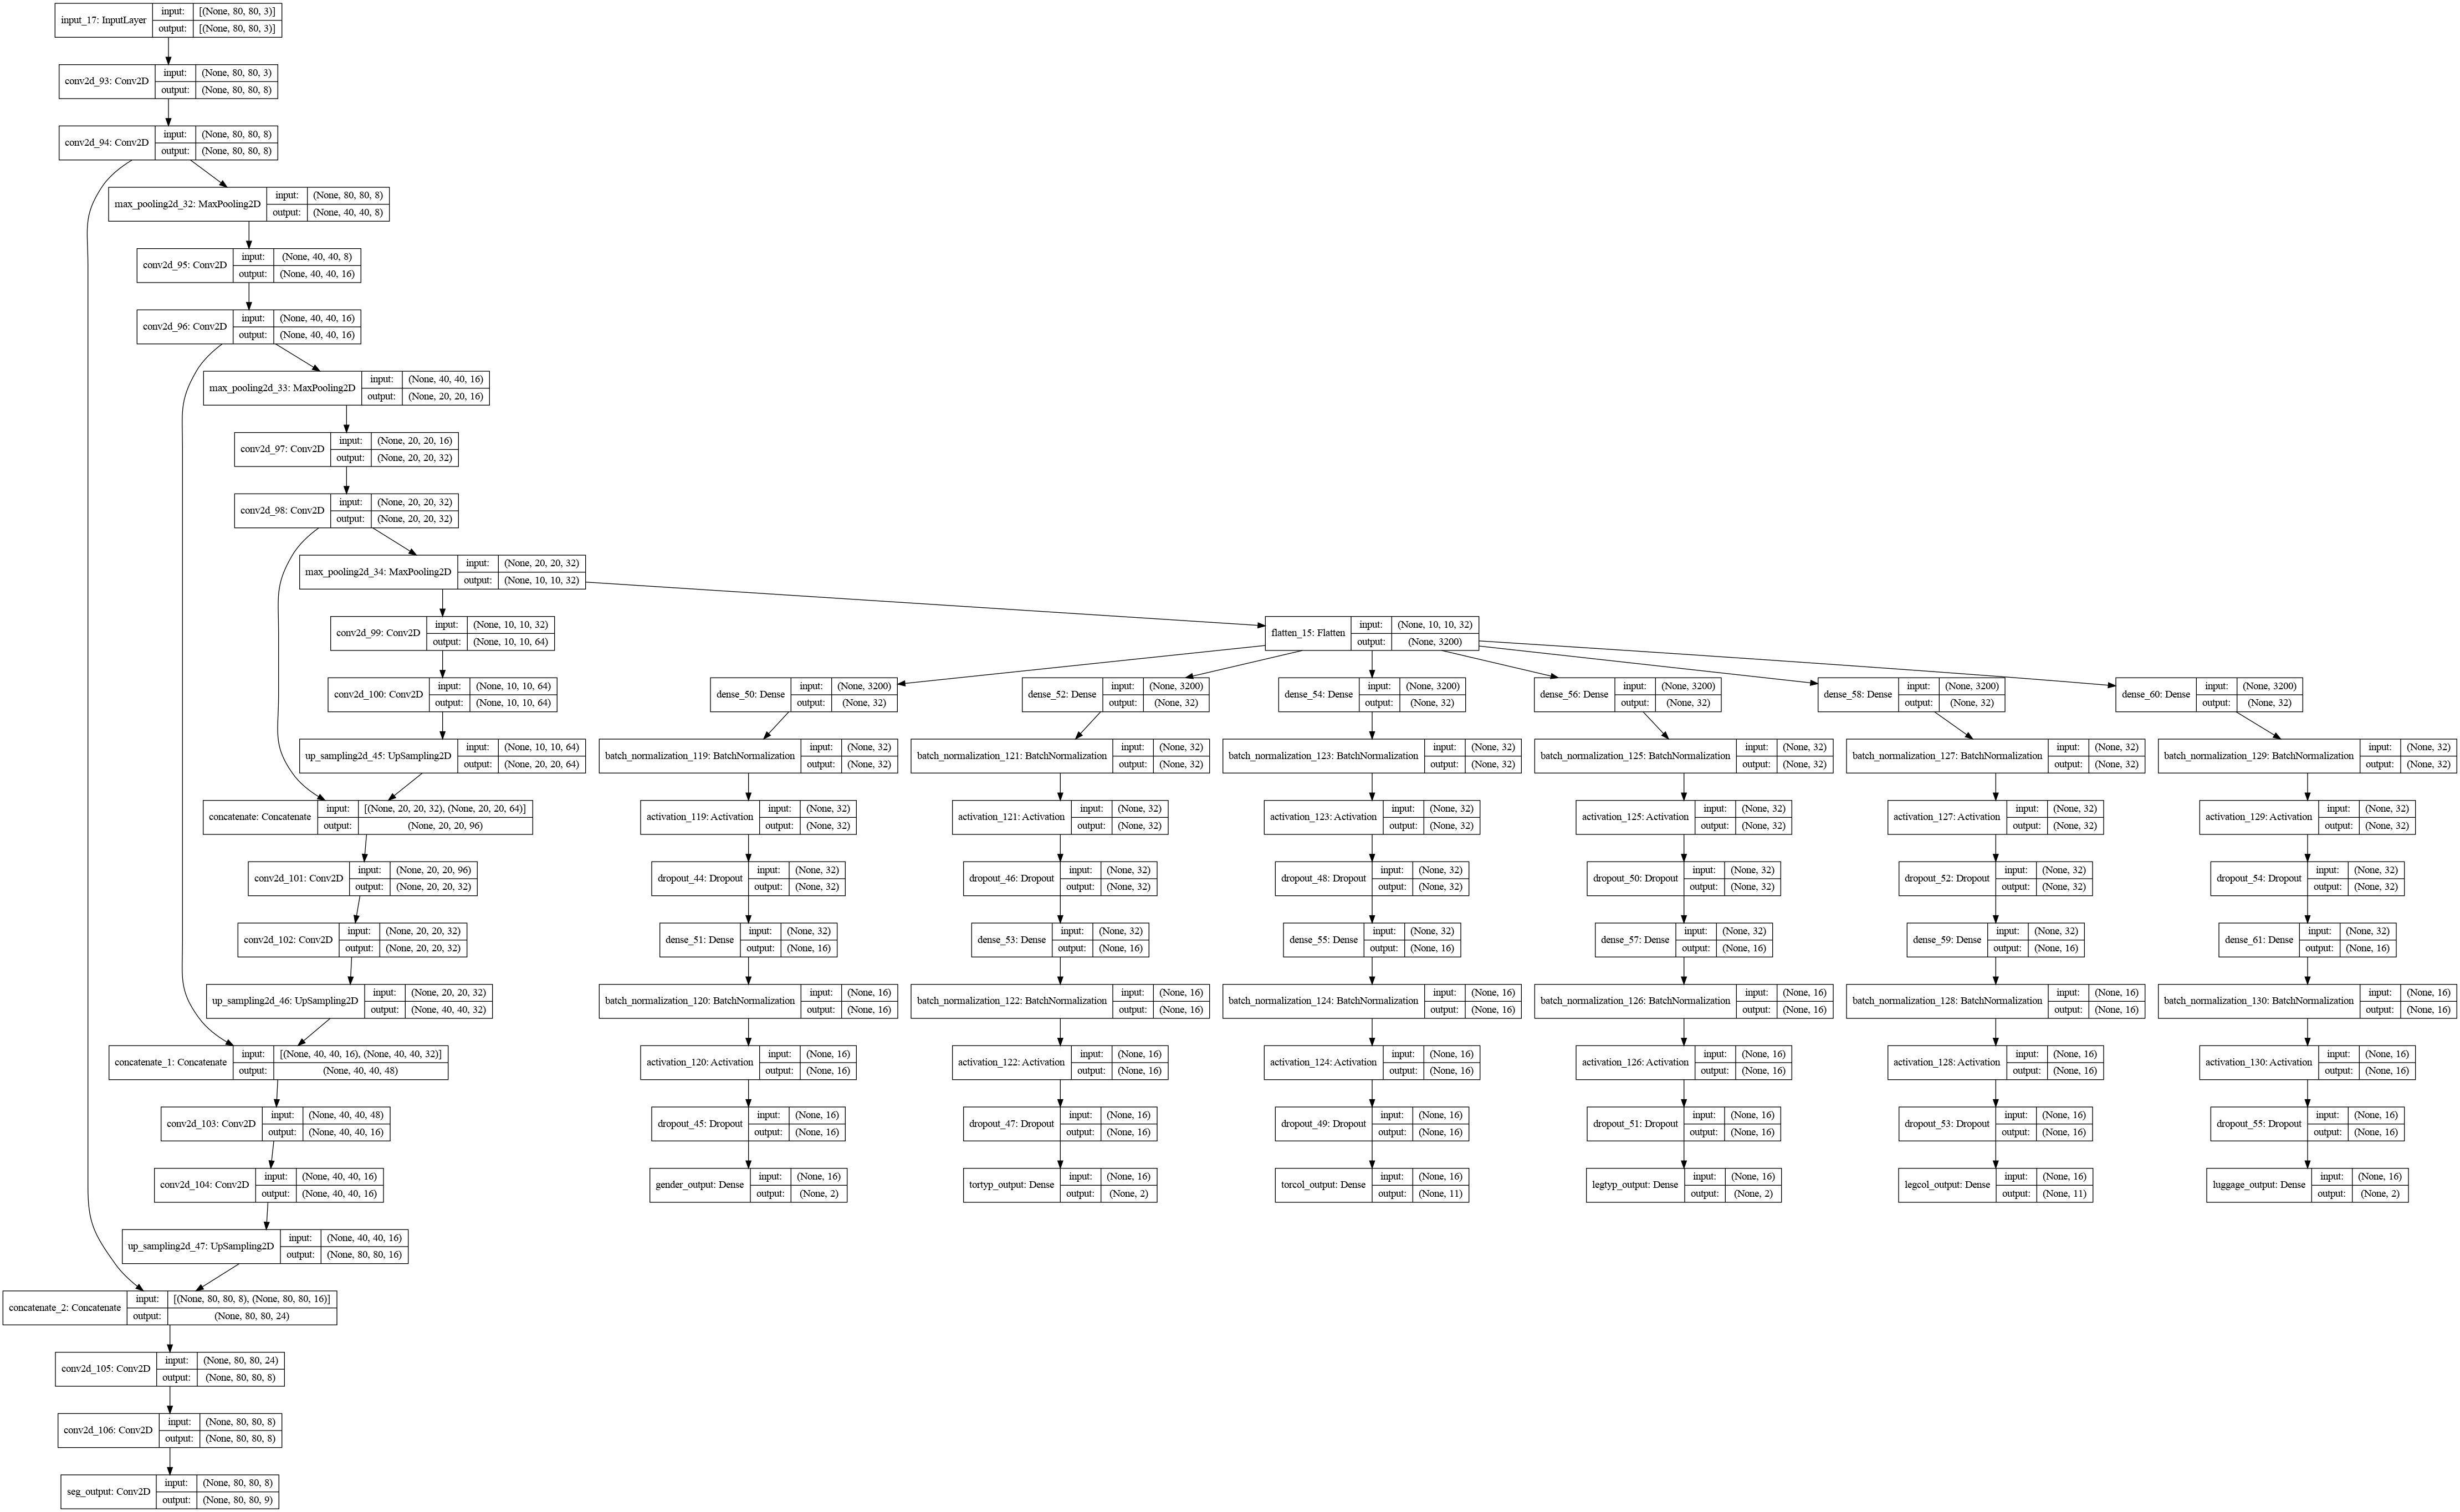

In [81]:
plot_model(multitask_cnn, to_file='test_keras_plot_model.png', show_shapes=True)
IPython.display.Image('test_keras_plot_model.png')

In [82]:
history = multitask_cnn.fit(X_train, [X_train_mask_categorical, y_train_gender, y_train_tortyp, y_train_torcol, y_train_legtyp, y_train_legcol, y_train_luggage],
                    batch_size=32,
                    epochs=300,
                    validation_split=0.2,
                    verbose = 0)

In [83]:
def eval_model(model, x_test, y_test1, y_test2, y_test3, y_test4, y_test5, y_test6, history):
    
    pred_seg, pred_gender, pred_tortyp, pred_torcol, pred_legtyp, pred_legcol, pred_luggage = model.predict(x_test);

    fig = plt.figure(figsize=[10, 6])
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(history.history['loss'], label="Training Loss")
    ax.plot(history.history['gender_output_loss'], label="Gender Loss")
    ax.plot(history.history['tortyp_output_loss'], label="Tortyp Loss")
    ax.plot(history.history['torcol_output_loss'], label="Torcol Loss")
    ax.plot(history.history['legtyp_output_loss'], label="Legtyp Loss")
    ax.plot(history.history['legcol_output_loss'], label="Legcol Loss")
    ax.plot(history.history['luggage_output_loss'], label="Luggage Loss")
    ax.plot(history.history['seg_output_loss'], label="Segmentation Loss")
    ax.legend()
    ax.set_title('Training Loss')

    fig = plt.figure(figsize=[10, 6])
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(history.history['val_loss'], label="Validation Loss")
    ax.plot(history.history['val_gender_output_loss'], label="Gender Loss")
    ax.plot(history.history['val_tortyp_output_loss'], label="Tortyp Loss")
    ax.plot(history.history['val_torcol_output_loss'], label="Torcol Loss")
    ax.plot(history.history['val_legtyp_output_loss'], label="Legtyp Loss")
    ax.plot(history.history['val_legcol_output_loss'], label="Legcol Loss")
    ax.plot(history.history['val_luggage_output_loss'], label="Luggage Loss")
    ax.plot(history.history['val_seg_output_loss'], label="Segmentation Loss")
    ax.legend()
    ax.set_title('Validation Loss')

    fig = plt.figure(figsize=[20, 10])

    indexes = tf.argmax(pred_gender, axis=1)
    gt = tf.argmax(y_test1, axis=1)
    cm = confusion_matrix(gt, indexes, labels=range(2), normalize='true')
    ax = fig.add_subplot(2, 3, 1)
    c = ConfusionMatrixDisplay(cm,display_labels=range(2))
    c.plot(ax = ax)
    ax.set_title('Gender')

    indexes = tf.argmax(pred_tortyp, axis=1)
    gt = tf.argmax(y_test2, axis=1)
    cm = confusion_matrix(gt, indexes, labels=range(2), normalize='true')
    ax = fig.add_subplot(2, 3, 2)
    c = ConfusionMatrixDisplay(cm,display_labels=range(2))
    c.plot(ax = ax)
    ax.set_title('Tortyp')

    indexes = tf.argmax(pred_torcol, axis=1)
    gt = tf.argmax(y_test3, axis=1)
    cm = confusion_matrix(gt, indexes, labels=range(11), normalize='true')
    ax = fig.add_subplot(2, 3, 3)
    c = ConfusionMatrixDisplay(cm, display_labels=range(11))
    c.plot(ax = ax)
    ax.set_title('Torcol')

    indexes = tf.argmax(pred_legtyp, axis=1)
    gt = tf.argmax(y_test4, axis=1)
    cm = confusion_matrix(gt, indexes, labels=range(2), normalize='true')
    ax = fig.add_subplot(2, 3, 4)
    c = ConfusionMatrixDisplay(cm, display_labels=range(2))
    c.plot(ax = ax)
    ax.set_title('Legtyp')

    indexes = tf.argmax(pred_legcol, axis=1)
    gt = tf.argmax(y_test5, axis=1)
    cm = confusion_matrix(gt, indexes, labels=range(11), normalize='true')
    ax = fig.add_subplot(2, 3, 5)
    c = ConfusionMatrixDisplay(cm, display_labels=range(11))
    c.plot(ax = ax)
    ax.set_title('Legcol')

    indexes = tf.argmax(pred_luggage, axis=1)
    gt = tf.argmax(y_test6, axis=1)
    cm = confusion_matrix(gt, indexes, labels=range(2), normalize='true')
    ax = fig.add_subplot(2, 3, 6)
    c = ConfusionMatrixDisplay(cm, display_labels=range(2))
    c.plot(ax = ax)
    ax.set_title('Luggage')

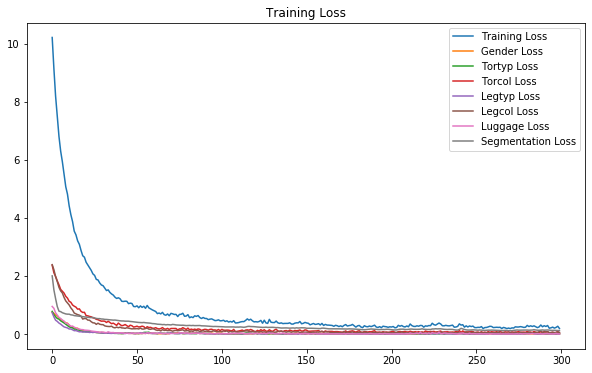

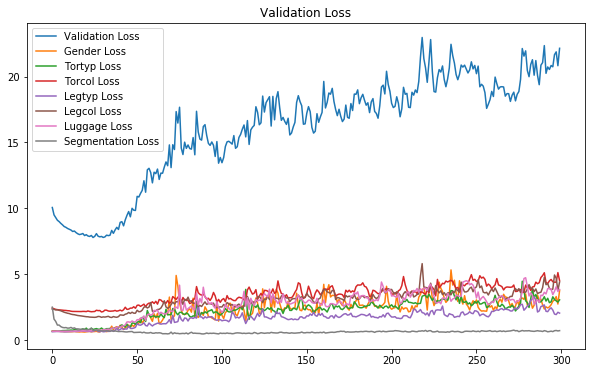

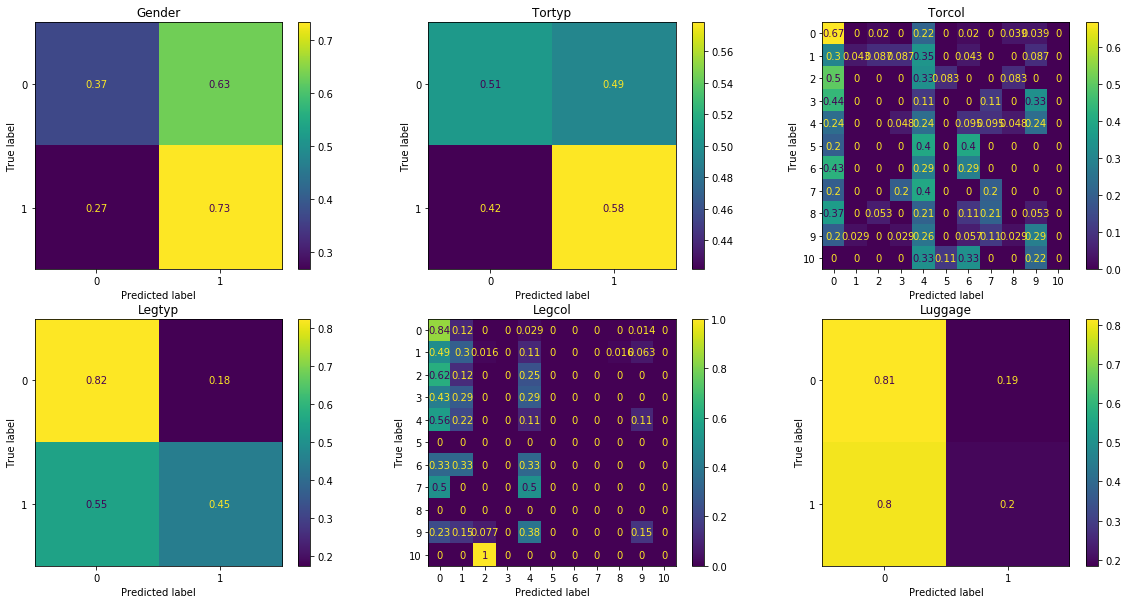

In [84]:
eval_model(multitask_cnn, X_test, y_test_gender, y_test_tortyp, y_test_torcol, y_test_legtyp, y_test_legcol, y_test_luggage, history)

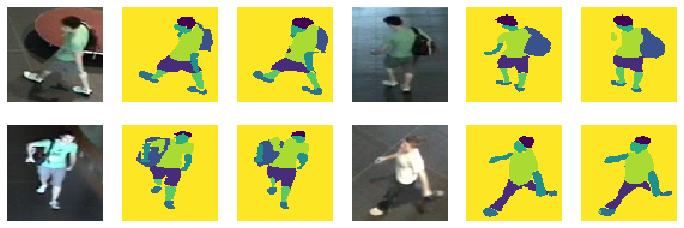

In [85]:
prediction_unet, _, _, _, _, _, _ = multitask_cnn.predict(X_train)
    
fig = plt.figure(figsize=[12, 4])
for i in range(4):
    ax = fig.add_subplot(2, 6, 3*i+1)
    ax.imshow(X_train[i,:,:,:])
    ax.set_axis_off()
    ax = fig.add_subplot(2, 6, 3*i+2)
    ax.imshow(categorical_to_mask(X_train_mask_categorical[i,:,:,:]))
    ax.set_axis_off()
    ax = fig.add_subplot(2, 6, 3*i+3)
    ax.imshow(categorical_to_mask(prediction_unet[i,:,:,:]))
    ax.set_axis_off()

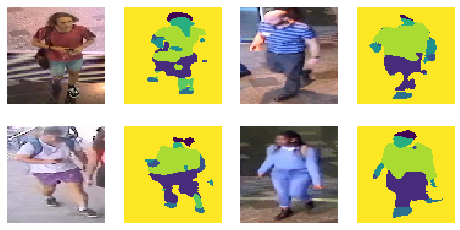

In [86]:
prediction_unet, _, _, _, _, _, _ = multitask_cnn.predict(X_test)
    
fig = plt.figure(figsize=[8, 4])
for i in range(4):
    ax = fig.add_subplot(2, 4, 2*i+1)
    ax.imshow(X_test[i,:,:,:])
    ax.set_axis_off()
    ax = fig.add_subplot(2, 4, 2*i+2)
    ax.imshow(categorical_to_mask(prediction_unet[i,:,:,:]))
    ax.set_axis_off()